In [1]:
import os
from hashlib import sha256
import random

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
from jose.helpers import file_functions
from lared.dataset.example import VideoExample, AudioExample, FullExample
from lared.data_loading.utils import get_video_caps, AudioFiles
from annotation.coco_reader import CocoReader
from lared_laughter.constants import raw_video_path, raw_audio_path, \
    processed_data_path, datasets_path, annot_exp_path as original_exp_path
from example_generation import make_folders, generate_media

In [4]:
VideoExample.init_caps(get_video_caps(raw_video_path))
VideoExample.init_camera_annotation(os.path.join(processed_data_path, 'elan_out/camera.txt'))
AudioExample.init_dataset(AudioFiles(raw_audio_path))

In [5]:
# load ELAN annotations
laughter_ann_path = os.path.join(processed_data_path, 'elan_out/laughter.txt')
# path for output images
annot_exp_path = os.path.join(os.environ['PROC_DATA_PATH'], 'lared_laughter', 'annotation_experiment_2')

laughter_ann = pd.read_csv(laughter_ann_path, sep='\t',names=['name','participant','ini','fin','dur','type'],header=None)
df_laughter_by_participant = laughter_ann.groupby('participant')

In [6]:
dfs_laughter = []
for i in df_laughter_by_participant.groups:
    dfs_laughter.append(df_laughter_by_participant.get_group(i))
participant_ids = df_laughter_by_participant.groups.keys()
participant_ids = [int(id) for id in participant_ids]

In [7]:
# total number of annotated laughter
sum([len(df) for df in dfs_laughter])

1838

# Apply episode threshold

In [8]:
dfs_laughter[0].tail(2)

,name,participant,ini,fin,dur,type
65,laughter1,1,6628.40,6629.84,1.44,laughter
66,laughter1,1,6630.84,6631.88,1.04,laughter


In [9]:
# join episodes/bouts that are closer than 1s in time
threshold = 1
num_deleted = 0
num_episodes = 0
for df in dfs_laughter:
    df.reset_index(inplace=True)
    to_delete = []
    for i, row in enumerate(df.iterrows()):
        num_episodes += 1
        if i == len(df)-1: 
            continue
        if (df.loc[i+1, 'ini'] - df.loc[i, 'fin']) < 1:
            df.loc[i+1, 'ini'] = df.loc[i, 'ini']
            to_delete.append(i)
    
    num_deleted += len(to_delete)
    df.drop(to_delete, inplace=True)
print(f'Joined / deleted: {num_deleted} / {num_episodes}')

Joined / deleted: 28 / 1838


/tmp/ipykernel_4163/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_4163/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_4163/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_4163/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set o

In [10]:
# add prev_fin and next_ini
for df in dfs_laughter:
    df.reset_index(inplace=True)
    prev_fin = []
    next_ini = []
    for i, row in enumerate(df.iterrows()):
        prev_fin.append(0 if i == 0 else df.loc[i-1, 'fin'])
        next_ini.append(1000000 if i == len(df)-1 else df.loc[i+1, 'ini'])
    df.insert(6, 'prev_fin', prev_fin)
    df.insert(7, 'next_ini', next_ini)

In [10]:
sum([len(df) for df in dfs_laughter])

1810

In [12]:
dfs_laughter[0].head(2)

,level_0,index,name,participant,ini,fin,prev_fin,next_ini,dur,type
0,0,0,laughter1,1,1028.28,1030.08,0.00,1049.98,1.80,laughter
1,1,1,laughter1,1,1049.98,1051.30,1030.08,1099.88,1.32,laughter


# Filter out segments of the interaction

In [13]:
# valid segments
# permisive
# [15:00 - 25:25]
# [27:00 - 40:50]
# [43:00 - 48:42]
# [49:00 - 1:30:35]
# [1:33:00 - 2:44:00]

# strict
# [16:30 - 25:25]
# [28:00 - 40:50]
# [43:00 - 48:42]
# [55:20 - 1:30:35]
# [1:33:00 - 2:44:00]

In [14]:
# checks if an example is within the valid parts of the interaction
# segments of the interaction where people are not in free-for-all were removed (made invalid)
# the fn returns false if the example is within those segments.
def is_valid(s):
    valid_segs = [
        [990, 1525],
        [1680, 2450],
        [2580, 2922],
        [3320, 5435],
        [5580, 9840]
    ]
    for seg in valid_segs:
        if s[0] >= seg[0] and s[1] < seg[1]:
            return True
    return False

def is_valid_row(row):
    return is_valid([row['ini'], row['fin']])

In [15]:
num_kept = 0
num_episodes = 0
for i, df in enumerate(dfs_laughter):
    m = df.apply(is_valid_row, axis=1)
    num_kept += np.sum(m)
    num_episodes += len(m)
    dfs_laughter[i] = df[m]
print(f'Kept: {num_kept} / {num_episodes}')

Kept: 1493 / 1810


# Laughter example: generation

generate the base set of laughter examples

In [16]:
random.seed(22)
np.random.seed(22)

In [17]:
# Pad and split examples
laughter_examples = dict()
camera_distrib = {0: 0, 1:0, 2:0, 3:0, 4:0}
for i, (pid, df_laughter) in tqdm(enumerate(zip(participant_ids, dfs_laughter))):
    for index,row in df_laughter.iterrows():
        ex = FullExample(
            pid= pid,
            ini_time= row['ini'],
            end_time= row['fin'])
        ex.random_pad(1.5, 3.5, min_ini=row['prev_fin'], max_end=row['next_ini'])
        ex.set_camera()
        exs = ex.split_by_camera()
        camera_distrib[len(exs)] += 1

        for example in exs:
            laughter_examples[example.get_hash()] = example

0it [00:00, ?it/s]

<BarContainer object of 5 artists>

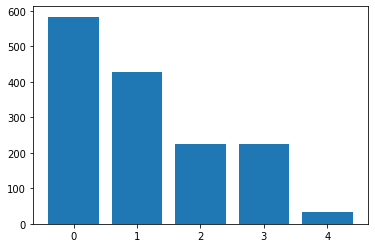

In [18]:
# distribution of num examples among subject IDs
plt.bar(camera_distrib.keys(), camera_distrib.values())

# Laughter examples: loading
load a previously generated set of examples

In [10]:
laughter_examples_df = pd.read_csv(os.path.join(annot_exp_path, 'laughter_examples', 'examples1.csv'), index_col=0)
laughter_examples = {ex[1].hash: FullExample(**ex[1].to_dict()) for ex in laughter_examples_df.iterrows()}

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/examples1.csv'

# Get the distribution

In [14]:
pid_distrib = {pid: 0 for pid in participant_ids}
for ex in laughter_examples.values():
    pid_distrib[ex.pid] += 1

<BarContainer object of 33 artists>

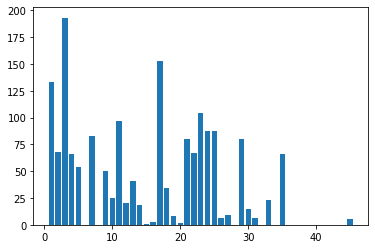

In [15]:
# distribution of num examples among subject IDs
plt.bar(pid_distrib.keys(), pid_distrib.values())

In [22]:
# write images for laughter examples
laughter_images_path = os.path.join(annot_exp_path, 'laughter_examples', 'images')
pilot_examples = random.sample(list(laughter_examples.values()), 1000)
for ex in tqdm(pilot_examples):
    ex.write_full_first_image(laughter_images_path)
(len(pilot_examples), len(laughter_examples))

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Speech / nonspeech segments

In [16]:
%load_ext autoreload
%autoreload 2
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

from lared.dataset.subject import Subject
from lared_laughter.constants import (
    raw_audio_path,
    vad_audio_path
)

In [17]:
audiofile_map = pd.read_csv('./annotation/audiofile_map.csv', index_col=0)
audiofile_map.head()

,ini,end
id,,
1,0,6652313
2,0,6082616
3,0,6130061
4,817914,6053613
5,772051,6430197


In [18]:
subjects=list(audiofile_map.index)

In [25]:
# calculate the pid distribution to get the same proportion of non-laughter segments
num_speech_examples = 200
df_distrib = pd.DataFrame(pid_distrib.items(), columns=['pid', 'num'])
df_distrib = df_distrib.set_index('pid')
df_distrib['num'] = num_speech_examples * df_distrib['num'] / df_distrib['num'].sum()
df_distrib['num'] = df_distrib['num'].round()
df_distrib = df_distrib.astype('uint16')

In [46]:
df_distrib.index

Int64Index([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 45],
           dtype='int64', name='pid')

In [71]:
# for each subject in the dataset
speech_examples = {}
subj_examples = {}
random.seed(24)
np.random.seed(24)
for pid, row in tqdm(audiofile_map.iterrows(), total=audiofile_map.shape[0]):
    pid = int(pid)
    # row = audiofile_map.iloc[pid,:]
    # print(row)

    subj = Subject(pid)
    subj.set_audio_path(os.path.join(raw_audio_path, f'{pid}.wav'))
    subj.set_vad_path(os.path.join(vad_audio_path, f'{pid}'))
    # subj.load_audio()
    subj.load_vad(row['ini'], row['end'])
    
    examples = subj.create_speech_thin_slices(
        df_distrib.loc[pid, 'num'], 
        df_laughter_by_participant.get_group(pid), 
        min_pad=1.5, max_pad=3.5, valid_fn=is_valid)

    print((pid, df_distrib.loc[pid, 'num'], len(examples)))
    subj_examples[pid] = examples
        
    for ex in examples:
        ex.set_camera()
        exs = ex.split_by_camera()
        for e in exs:
            speech_examples[e.get_hash()] = e

  3%|▎         | 1/32 [00:01<00:43,  1.41s/it]

(1, 16, 16)


  6%|▋         | 2/32 [00:03<00:46,  1.54s/it]

(2, 8, 8)


  9%|▉         | 3/32 [00:05<00:52,  1.81s/it]

(3, 23, 23)


 12%|█▎        | 4/32 [00:06<00:42,  1.51s/it]

(4, 8, 8)


 16%|█▌        | 5/32 [00:08<00:46,  1.74s/it]

(5, 6, 6)


 19%|█▉        | 6/32 [00:10<00:45,  1.76s/it]

(7, 10, 10)


 22%|██▏       | 7/32 [00:11<00:38,  1.54s/it]

(35, 8, 8)


 25%|██▌       | 8/32 [00:13<00:44,  1.86s/it]

(9, 6, 6)


 28%|██▊       | 9/32 [00:14<00:36,  1.60s/it]

(10, 3, 3)


 31%|███▏      | 10/32 [00:16<00:35,  1.61s/it]

(11, 12, 12)


 34%|███▍      | 11/32 [00:17<00:29,  1.40s/it]

(12, 2, 2)


 38%|███▊      | 12/32 [00:18<00:26,  1.31s/it]

(13, 5, 5)


 41%|████      | 13/32 [00:19<00:22,  1.19s/it]

(14, 2, 2)


 44%|████▍     | 14/32 [00:21<00:25,  1.41s/it]

(15, 0, 0)


 47%|████▋     | 15/32 [00:21<00:19,  1.16s/it]

(45, 1, 1)


 50%|█████     | 16/32 [00:23<00:21,  1.31s/it]

(17, 18, 18)


 53%|█████▎    | 17/32 [00:24<00:18,  1.26s/it]

(18, 4, 4)


 56%|█████▋    | 18/32 [00:25<00:14,  1.06s/it]

(19, 1, 1)


 59%|█████▉    | 19/32 [00:27<00:19,  1.52s/it]

(20, 0, 0)


 62%|██████▎   | 20/32 [00:30<00:22,  1.88s/it]

(21, 10, 10)


 66%|██████▌   | 21/32 [00:31<00:17,  1.61s/it]

(22, 8, 8)


 69%|██████▉   | 22/32 [00:33<00:17,  1.76s/it]

(23, 12, 12)


 72%|███████▏  | 23/32 [00:35<00:16,  1.83s/it]

(24, 10, 10)


 75%|███████▌  | 24/32 [00:37<00:13,  1.72s/it]

(25, 10, 10)


 78%|███████▊  | 25/32 [00:38<00:11,  1.68s/it]

(26, 1, 1)


 81%|████████▏ | 26/32 [00:39<00:08,  1.37s/it]

(27, 1, 1)


 84%|████████▍ | 27/32 [00:40<00:06,  1.29s/it]

(29, 10, 10)


 88%|████████▊ | 28/32 [00:41<00:05,  1.30s/it]

(30, 2, 2)


 91%|█████████ | 29/32 [00:42<00:03,  1.09s/it]

(31, 1, 1)


 94%|█████████▍| 30/32 [00:43<00:02,  1.08s/it]

(32, 0, 0)


 97%|█████████▋| 31/32 [00:44<00:00,  1.01it/s]

(33, 3, 3)


100%|██████████| 32/32 [00:45<00:00,  1.41s/it]

(34, 0, 0)


In [72]:
[len(se) for se in subj_examples.values()]

[16,
 8,
 23,
 8,
 6,
 10,
 8,
 6,
 3,
 12,
 2,
 5,
 2,
 0,
 1,
 18,
 4,
 1,
 0,
 10,
 8,
 12,
 10,
 10,
 1,
 1,
 10,
 2,
 1,
 0,
 3,
 0]

In [73]:
len(speech_examples)

341

In [74]:
# write images for speech examples
speech_images_path = os.path.join(annot_exp_path, 'speech_examples', 'images')
# pilot_examples = random.sample(list(speech_examples.values()), 60)
for ex in tqdm(speech_examples.values()):
    ex.write_full_first_image(speech_images_path)
# (len(pilot_examples), len(speech_examples))

100%|██████████| 341/341 [00:30<00:00, 11.02it/s]


In [75]:
speech_examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
speech_examples_df = pd.DataFrame(speech_examples_dicts)
speech_examples_df.to_csv(os.path.join(annot_exp_path, 'speech_examples', 'examples.csv'))

In [43]:
speech_examples_df.head()

,id,pid,cam,valid,hash,_ini_time,_end_time,ini_time,end_time,labels,rect,ini,len
0,None,1,1,True,eea2ae3173c1f0aaee3ea9e9f1a28af988e36fafe7ecbc...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
1,None,1,2,True,24c071c511535383396bc9c297e3e083cd1b7f5560fc2c...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
2,None,1,3,True,a4356f265b9706b9655e3a592a198ad5dc26caa0358a06...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
3,None,1,4,True,76ff8820bb59a3db222b74caef561286974c2b6f8360e3...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
4,None,1,1,True,fa27e8c128e63d8858559cb67538e1b3b0cd16a470faa8...,2584.778415,2590.142226,2584.778415,2590.142226,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None


# Read CVAT annotations

  0%|          | 0/444 [00:00<?, ?it/s]

ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_1d71a6a35c39a2da05853cec3bcfc4bc1d5ab0c2ee384161d8f49b0a5a8d51d8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_1d71a6a35c39a2da05853cec3bcfc4bc1d5ab0c2ee384161d8f49b0a5a8d51d8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_b4d805dfb44c728976b4c58bb1d6d0dacf093ee151e867afb1ba3e17fb85192c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_b4d805dfb44c728976b4c58bb1d6d0dacf093ee151e867afb1ba3e17fb85192c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_a632769d2c4d12e7d9a30532b4942fa80c0036021cab05200d887b4013b95f9f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_a632769d2c4d12e7d9a30532b4942fa80c0036021cab05200d887b4013b95f9f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_01dccf620d03a3dc911fecc13807c2adf74c934be16c3337568451c7c19c48c9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_01dccf620d03a3dc911fecc13807c2adf74c934be16c3337568451c7c19c48c9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_3d697aef37aa7eafb811ec25243ceb2b4ff73253c521afb4ffd28e3d2554ce53_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_3d697aef37aa7eafb811ec25243ceb2b4ff73253c521afb4ffd28e3d2554ce53_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_d83809c0ef2a8b662fb58e7cf5fbbad91a1d360500eae1894da55f57efcdf569_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_d83809c0ef2a8b662fb58e7cf5fbbad91a1d360500eae1894da55f57efcdf569_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_22474ef5959686583af861f21ed4c1bda03b8547af0b55c39ad9a90e48c4a412_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_22474ef5959686583af861f21ed4c1bda03b8547af0b55c39ad9a90e48c4a412_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_1c42709ebc64e4d8997cef8096ed5ad3bae247e531348254bc00419159c8119f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_1c42709ebc64e4d8997cef8096ed5ad3bae247e531348254bc00419159c8119f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_6a5080d3098e23764150ff6235cbd9bc36bfe91f59507138096cf5ccf7fb37e4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_6a5080d3098e23764150ff6235cbd9bc36bfe91f59507138096cf5ccf7fb37e4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_e9e3a10794af7819df5e0817ac42f306c094e940efe49c9ad9961f366023ade7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_e9e3a10794af7819df5e0817ac42f306c094e940efe49c9ad9961f366023ade7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_957de4632858088197ddc57e1aa72a014d5c8b7c98453e88a95af32dff78ecfc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_957de4632858088197ddc57e1aa72a014d5c8b7c98453e88a95af32dff78ecfc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_d2c0d64173ee6e01dfd42b2595114a651a0b39aac268f73109b2dfbf7080ac54_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_d2c0d64173ee6e01dfd42b2595114a651a0b39aac268f73109b2dfbf7080ac54_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_1dc73ae81c67a1f5d8527c9cf8b2bd70c19e4bbe83f774dda72456fed3c5bab7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_1dc73ae81c67a1f5d8527c9cf8b2bd70c19e4bbe83f774dda72456fed3c5bab7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_5bd662d033822ea10ea6b81a2248a637f78be4c3c64281260dc68950e43e6401_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_5bd662d033822ea10ea6b81a2248a637f78be4c3c64281260dc68950e43e6401_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_ac4bf9a0631c45aca768bd25fc8d52632bc793154eae6ee2c3f479e2023b5296_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_ac4bf9a0631c45aca768bd25fc8d52632bc793154eae6ee2c3f479e2023b5296_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_1e8c82da1fc9922d2033bfb98de495c8ed242f9f5d81eac891a7e9b47f0e10f9_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_1e8c82da1fc9922d2033bfb98de495c8ed242f9f5d81eac891a7e9b47f0e10f9_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_a1645bd101919c53f9222e8c21151d1f9f25571af3af6a38063bdd203db1c54b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_a1645bd101919c53f9222e8c21151d1f9f25571af3af6a38063bdd203db1c54b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_49f6eaafdf333bf34bd75f30a2767c105c03d1809f181faddcab48cc1e952855_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_49f6eaafdf333bf34bd75f30a2767c105c03d1809f181faddcab48cc1e952855_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_f481745135014722e45995eafdc648d6c33f27dbe06dcbd3e093d077fb68ee2d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_f481745135014722e45995eafdc648d6c33f27dbe06dcbd3e093d077fb68ee2d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_71615a5024ba1347ab509460dd4e8a2ff4832b8aeac6e0466fb04fd04754e47c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_71615a5024ba1347ab509460dd4e8a2ff4832b8aeac6e0466fb04fd04754e47c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_b0f103f2a155fc938fcf70ed3791a9e299629a7c52b6afb93cd5e7831cbfeedb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_b0f103f2a155fc938fcf70ed3791a9e299629a7c52b6afb93cd5e7831cbfeedb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_8bac35334235a22c47b215bd2b78b5515c538c19d3f4e17844631d27f5612a66_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_8bac35334235a22c47b215bd2b78b5515c538c19d3f4e17844631d27f5612a66_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_4e36c48503e0026a63b04ef67356414429d02614911f7722708e17c8d000b0aa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_4e36c48503e0026a63b04ef67356414429d02614911f7722708e17c8d000b0aa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_49b95c9adeb737f924065822b5b2706d8e9205dfc68d7b265429e328196a660a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_49b95c9adeb737f924065822b5b2706d8e9205dfc68d7b265429e328196a660a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_d0f89ff6a3ca43422ebc0b55daddcdfa5853c8e8852d069fcbf402829db02f0e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_d0f89ff6a3ca43422ebc0b55daddcdfa5853c8e8852d069fcbf402829db02f0e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_064cb30748a9c7d6fe7b8a33d0b587cef3c3c0326cbe939036849915f7e5c3ef_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_064cb30748a9c7d6fe7b8a33d0b587cef3c3c0326cbe939036849915f7e5c3ef_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_1c57f6da3cc0f15b7b9a9f7160f8ec2911af8e8343b06930ecdf428a8c81e082_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_1c57f6da3cc0f15b7b9a9f7160f8ec2911af8e8343b06930ecdf428a8c81e082_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_01d6ec31f5b002ed99f441584e4e933e50355d86668d4d46f663e3c3e05f3c94_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_01d6ec31f5b002ed99f441584e4e933e50355d86668d4d46f663e3c3e05f3c94_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/01_c6f1c1c2aa66a8dcdfb03e29695df70034622ad739eb4aa9d8e4d8bc2f589be4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/01_c6f1c1c2aa66a8dcdfb03e29695df70034622ad739eb4aa9d8e4d8bc2f589be4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_5493107dcccfa67f96709b24c5da2d1248f86a5256e9ccc9fc633beb3ad93a43_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_5493107dcccfa67f96709b24c5da2d1248f86a5256e9ccc9fc633beb3ad93a43_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_1a3a5272081f243827854c94828e619c797f3c9928caf355cdf7cccd0bd893f9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_1a3a5272081f243827854c94828e619c797f3c9928caf355cdf7cccd0bd893f9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_8f19f934af34388e8141494040d9ce0e6720ae5e29411989238627a4faa489f4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_8f19f934af34388e8141494040d9ce0e6720ae5e29411989238627a4faa489f4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_3dabbbcf6719e2300aaca16b1e3d6d2db156d8ea82161dba2173c35e0eff8ba6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_3dabbbcf6719e2300aaca16b1e3d6d2db156d8ea82161dba2173c35e0eff8ba6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_349bf1ef3e7be69021e9e811374e0df948d62d8dc5ead61a443547b132af47dc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_349bf1ef3e7be69021e9e811374e0df948d62d8dc5ead61a443547b132af47dc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_fcc99248406e5fe48a3d733d5945462aa221ef528c46c6e36c5eae852e4ce393_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_fcc99248406e5fe48a3d733d5945462aa221ef528c46c6e36c5eae852e4ce393_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_f023504606d4e4d5f4495e5ed31614b99441e6bac8e0f8d4c951001a080dea9b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_f023504606d4e4d5f4495e5ed31614b99441e6bac8e0f8d4c951001a080dea9b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_f5509fd18f58d99106b5bd766979e82d622ffaa5f9c049ab41e5c17ace457d20_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_f5509fd18f58d99106b5bd766979e82d622ffaa5f9c049ab41e5c17ace457d20_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_7660d7de05980b4ca28b01e1dfba27dc404af1b31f0226381e372b457815edd6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_7660d7de05980b4ca28b01e1dfba27dc404af1b31f0226381e372b457815edd6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_0612effc4423af326d222700ede34b0af09207bac0388c75530200dc4a38eefa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_0612effc4423af326d222700ede34b0af09207bac0388c75530200dc4a38eefa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_a7a1dcc3b627f5fa0bcd6359b5c487d6300c4fe73fe1ee462d09de9aa91e9f22_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_a7a1dcc3b627f5fa0bcd6359b5c487d6300c4fe73fe1ee462d09de9aa91e9f22_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_eec74057bfcd89e005c55ff420748e3482cb2dc4fdd1502af1e2b73b8c563698_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_eec74057bfcd89e005c55ff420748e3482cb2dc4fdd1502af1e2b73b8c563698_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_a53e5c31bd405d39897fcc139954b2731e0e7567c051e5b1a62106118806fdcf_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_a53e5c31bd405d39897fcc139954b2731e0e7567c051e5b1a62106118806fdcf_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_d6ec432b73bc1ddd406a8bc89ac2a9d226ff86ae85cdc061297172fd73e50390_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_d6ec432b73bc1ddd406a8bc89ac2a9d226ff86ae85cdc061297172fd73e50390_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_fcfc2038e54ccb8b862404d06ae3e57302a7735e5dad51cc88d41270f672c7fb_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_fcfc2038e54ccb8b862404d06ae3e57302a7735e5dad51cc88d41270f672c7fb_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_7ff1d890dabd1efbf10a420011e1706b634c64c6984addf0d0ae83cb4b59c2c7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_7ff1d890dabd1efbf10a420011e1706b634c64c6984addf0d0ae83cb4b59c2c7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/02_2f4eaa3497b6f5e3dbb7f487eebe1408e2dfcfc85e00b3cbb671650695ffa93b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/02_2f4eaa3497b6f5e3dbb7f487eebe1408e2dfcfc85e00b3cbb671650695ffa93b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_b39d3d316ef5f9b8b70462addb8aab98a780f3dc035bda02761845e6724620c6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_b39d3d316ef5f9b8b70462addb8aab98a780f3dc035bda02761845e6724620c6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_045649b09dc55cd7d503f738e5a1388e7d20005dea8c450d40f546704189bab9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_045649b09dc55cd7d503f738e5a1388e7d20005dea8c450d40f546704189bab9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_21ad4bf4dd92f32cf34224c6bea4a3246511ffda6cffac8c6883ee0fcbba0ca8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_21ad4bf4dd92f32cf34224c6bea4a3246511ffda6cffac8c6883ee0fcbba0ca8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_8a155aa76d39bedfd5084cc44c9163efcadd78792511b56f411feb96949d7a10_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_8a155aa76d39bedfd5084cc44c9163efcadd78792511b56f411feb96949d7a10_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_58566fc8aa07980317baa16a82b5b86894493ee3c8ebdcd95e8d7aacf2269592_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_58566fc8aa07980317baa16a82b5b86894493ee3c8ebdcd95e8d7aacf2269592_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_9977044a0b92e0dfa0156d8796dd851005aa790cd77ae55adec6e3504f96214c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_9977044a0b92e0dfa0156d8796dd851005aa790cd77ae55adec6e3504f96214c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_ee45df1e07eb96f50cc2488bed457eb7ccc299ff7ad39e5fd6d5c0a8992d3efb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_ee45df1e07eb96f50cc2488bed457eb7ccc299ff7ad39e5fd6d5c0a8992d3efb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_a334bc1bcb8248fd2131550e1510016de472989321ca855604cb3e4f78e10b20_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_a334bc1bcb8248fd2131550e1510016de472989321ca855604cb3e4f78e10b20_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_02da02e20d4a685ba75f1afdafcd3933ca1b7d38a4a4a230dd4df08e88adbe25_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_02da02e20d4a685ba75f1afdafcd3933ca1b7d38a4a4a230dd4df08e88adbe25_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_340568672628bf84687240cfc8e16abd9419a718a5dea2ea414e36fd1c8dff77_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_340568672628bf84687240cfc8e16abd9419a718a5dea2ea414e36fd1c8dff77_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_1fc07323dbc56b435d361be3c648cd60873f23bca08e4940d86ad112c0085a01_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_1fc07323dbc56b435d361be3c648cd60873f23bca08e4940d86ad112c0085a01_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_aa1a704eb629ad860a277b9fad822dccbbb88668a0cc379b4ef6835597dc221a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_aa1a704eb629ad860a277b9fad822dccbbb88668a0cc379b4ef6835597dc221a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_686f8b244157cd68f2e437f8529de3d01057d504ca3895ce41269caa61a7feb0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_686f8b244157cd68f2e437f8529de3d01057d504ca3895ce41269caa61a7feb0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_cc5fc13bf0caa6e7cc43436bc4bcf8674083dd57967ed24384d1634a9a5cc702_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_cc5fc13bf0caa6e7cc43436bc4bcf8674083dd57967ed24384d1634a9a5cc702_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_cf02a3f3002246e22d1cd4ca1c7331ef8297f49c69e58fae2658642b581196b8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_cf02a3f3002246e22d1cd4ca1c7331ef8297f49c69e58fae2658642b581196b8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_49d3f5c13facf9c51ff6a4e4ab797a8c90a89f4652caa9ea9b2aeed9833e8a49_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_49d3f5c13facf9c51ff6a4e4ab797a8c90a89f4652caa9ea9b2aeed9833e8a49_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_24faa53636189821112a8562cd859443f841f2fc80d833291220bddcc3234239_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_24faa53636189821112a8562cd859443f841f2fc80d833291220bddcc3234239_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_d4003aa88a1662428c7b1f35412e5bf37c1d7eb047e8f45d4438173ff95c5298_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_d4003aa88a1662428c7b1f35412e5bf37c1d7eb047e8f45d4438173ff95c5298_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_d69549897419c95bc1657742606db2dee97e123ff768e6c55854333be9052548_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_d69549897419c95bc1657742606db2dee97e123ff768e6c55854333be9052548_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_bba3ad1eb3a5f0a65c10d13c04fa2525640058a0c3a0d7227bc913fc0fdbb88b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_bba3ad1eb3a5f0a65c10d13c04fa2525640058a0c3a0d7227bc913fc0fdbb88b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_f32f7d60614ebe4f14b4d2b6138be670649d07b2a37561461222eca572d91949_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_f32f7d60614ebe4f14b4d2b6138be670649d07b2a37561461222eca572d91949_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_7325f69c8b5a9cf861503dc5f5793ee7b99babe401069753665a066f744cb903_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_7325f69c8b5a9cf861503dc5f5793ee7b99babe401069753665a066f744cb903_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_5f9e32be26ac2dcd4397ac684d7453e6b93627adb2fd94ca63c8565c2b2e45c9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_5f9e32be26ac2dcd4397ac684d7453e6b93627adb2fd94ca63c8565c2b2e45c9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_6525d4140ad98f85c6ae2bcdbd0e492127dccc161ce5a8be980e0c62e40f99fe_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_6525d4140ad98f85c6ae2bcdbd0e492127dccc161ce5a8be980e0c62e40f99fe_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_588e13165d6267bf905bbb192cd40f7a6c0a9b7bdc13edbf8e280826a8a22a19_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_588e13165d6267bf905bbb192cd40f7a6c0a9b7bdc13edbf8e280826a8a22a19_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_2c72605d40dff89d61b99763362060fcd1d9eccbd475f96ba8484c1645b77d74_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_2c72605d40dff89d61b99763362060fcd1d9eccbd475f96ba8484c1645b77d74_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_b5a41883bc1f51a140b5a14adc0265f9d05cca521573d5a18b011837d32376c9_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_b5a41883bc1f51a140b5a14adc0265f9d05cca521573d5a18b011837d32376c9_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_f259983cdac47836582b428a9edad3a65ded63ef035dd4f97b01828136b20d2f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_f259983cdac47836582b428a9edad3a65ded63ef035dd4f97b01828136b20d2f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_433487baab1d4d4e4edcc1426a9a3b8b945ff3020ee8f8f0014d6224615a155f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_433487baab1d4d4e4edcc1426a9a3b8b945ff3020ee8f8f0014d6224615a155f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_453aa0dcdcd4292490bb270baaf3d09cd07a3b3af07f4473555f3da053188e48_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_453aa0dcdcd4292490bb270baaf3d09cd07a3b3af07f4473555f3da053188e48_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_91d181d5d3be9d64287356caa140bffe16475133dbccce25447ec4e18d1cee10_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_91d181d5d3be9d64287356caa140bffe16475133dbccce25447ec4e18d1cee10_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_44e055a8504e40d847e19706b59aaf1d1cae633db158f94146cf305527e57633_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_44e055a8504e40d847e19706b59aaf1d1cae633db158f94146cf305527e57633_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_a3fe2884f7d83be839f4925b4d49950ac00391b4f1ba47900e6a66a144dacb7b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_a3fe2884f7d83be839f4925b4d49950ac00391b4f1ba47900e6a66a144dacb7b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_9061d56e2830fc644708e0cf2ea431d28e763870b9464349c8a9b309a37d5bcd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_9061d56e2830fc644708e0cf2ea431d28e763870b9464349c8a9b309a37d5bcd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_72a29974b8a1855b1976660687a668a3d788c1ecabe8a31b19799ee5ff340a6e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_72a29974b8a1855b1976660687a668a3d788c1ecabe8a31b19799ee5ff340a6e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_91af6834b7df0d912222d644de580b08171ed37295fb93babbe94346d2bceb3c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_91af6834b7df0d912222d644de580b08171ed37295fb93babbe94346d2bceb3c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_29d988c96eeb2bd8cf2eda3467f33369306fd91c55f807e1eca4db9e49c4d3d2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_29d988c96eeb2bd8cf2eda3467f33369306fd91c55f807e1eca4db9e49c4d3d2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_35c343fe973cb490bd34990e6b05885139a1792e2e70e560fe2c519d62ce1de2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_35c343fe973cb490bd34990e6b05885139a1792e2e70e560fe2c519d62ce1de2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_5c941b92f12a05fe5d34ce33050b6aeedb5f76f350905a2949f2532fde807deb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_5c941b92f12a05fe5d34ce33050b6aeedb5f76f350905a2949f2532fde807deb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_bce2748b7bc082750e0f78dc4a79d998dfdef5c6a26bc188af8fc0363312b805_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_bce2748b7bc082750e0f78dc4a79d998dfdef5c6a26bc188af8fc0363312b805_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_e72702fa173695d52c525e34a3d0a8bb1df33f45108293a761558afe7d5d17ca_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_e72702fa173695d52c525e34a3d0a8bb1df33f45108293a761558afe7d5d17ca_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_1c90eb53051f81eacb1f4b075961e929d0e22f86fd4ba6f5bf096c9c327290dc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_1c90eb53051f81eacb1f4b075961e929d0e22f86fd4ba6f5bf096c9c327290dc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_0fc7d5a14daba91ea7cdc5962d809fcbe149a04256cddd850f127e4ac8018e17_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_0fc7d5a14daba91ea7cdc5962d809fcbe149a04256cddd850f127e4ac8018e17_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_27a96738606c2084161573e5cb33b41399998957bc49a02159f1584b90694629_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_27a96738606c2084161573e5cb33b41399998957bc49a02159f1584b90694629_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_bd8ae33eb78788c4afe6054d457b1f41c0069173117b8a197ad107aea6a2fad5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_bd8ae33eb78788c4afe6054d457b1f41c0069173117b8a197ad107aea6a2fad5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_736199d601e7d0b313ee9af5b50b9076b499636d8124a6e05d10c9f3a3d8e849_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_736199d601e7d0b313ee9af5b50b9076b499636d8124a6e05d10c9f3a3d8e849_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_ea9e5446fbe1e5c96bf967931879db03a15bfda597a0308a93980863a475605d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_ea9e5446fbe1e5c96bf967931879db03a15bfda597a0308a93980863a475605d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_10d0e849b7a65abb582d5765fcecd2fbd9f4c7b935a1f71abe572c5d20d8f4e4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_10d0e849b7a65abb582d5765fcecd2fbd9f4c7b935a1f71abe572c5d20d8f4e4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_84ca0c9904f754514e1d8b0b2aa4cb7dba093d652d07504efba81e049b2bfa9e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_84ca0c9904f754514e1d8b0b2aa4cb7dba093d652d07504efba81e049b2bfa9e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_60a8adeb2bccc3059d50ca3d08e231cbc0cf047eb6c47592fe3da9c09b3e14cf_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_60a8adeb2bccc3059d50ca3d08e231cbc0cf047eb6c47592fe3da9c09b3e14cf_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_b81a1f9873df91897d1368c89621706514e035a25718b3974747f5e671ef60ba_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_b81a1f9873df91897d1368c89621706514e035a25718b3974747f5e671ef60ba_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_8b2400ad8679da02ba36afca713d5f2f23f9aad218aa8e82882a549ed081332a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_8b2400ad8679da02ba36afca713d5f2f23f9aad218aa8e82882a549ed081332a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_9addecc0c94e44180d10861e242f1492918f9db3c546abbf88ecf7d24321d828_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_9addecc0c94e44180d10861e242f1492918f9db3c546abbf88ecf7d24321d828_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_1d99a8ed5a5633bd7326e7d3d467ef5d398ec483a782f16983181e634a1e797b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_1d99a8ed5a5633bd7326e7d3d467ef5d398ec483a782f16983181e634a1e797b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_e3feda390e444a150347da1440cc1f57b584c7d79fa1bc15d35674826b29ec2e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_e3feda390e444a150347da1440cc1f57b584c7d79fa1bc15d35674826b29ec2e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_891da6618c0681ce0e5e3fa7459584caad809b21d9a9d9b6be44212b58c3b4aa_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_891da6618c0681ce0e5e3fa7459584caad809b21d9a9d9b6be44212b58c3b4aa_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/03_0fdfeae1bcc5261836ffd0454ebbdaec41a1a756983e33d0fb8e5a3720a1c71c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/03_0fdfeae1bcc5261836ffd0454ebbdaec41a1a756983e33d0fb8e5a3720a1c71c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_c14f6433a1610214ec0bfed9907912b4ec891bfab418fad1d9290e0795d31ddc_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_c14f6433a1610214ec0bfed9907912b4ec891bfab418fad1d9290e0795d31ddc_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_32b11544fa1b433099f8932b90a4dd5b391f0fca8148cb54e607898c9156ea44_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_32b11544fa1b433099f8932b90a4dd5b391f0fca8148cb54e607898c9156ea44_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_5e4c950c7513205d1cea44d48f823221a4e924b14aa52338e63e16c61e1259cb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_5e4c950c7513205d1cea44d48f823221a4e924b14aa52338e63e16c61e1259cb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_0160da1890b3fc4a923586e460bb781ada3bc56ea9908aea299ce3828a629c42_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_0160da1890b3fc4a923586e460bb781ada3bc56ea9908aea299ce3828a629c42_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_4f9bf2dfcc3dfb0d2fd59c82d5f5205baeec2de32f55dca7243643553738ca8b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_4f9bf2dfcc3dfb0d2fd59c82d5f5205baeec2de32f55dca7243643553738ca8b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_03897d9e129b66d76f59be67e802b83675499338c07d502bdfbcfd5115319997_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_03897d9e129b66d76f59be67e802b83675499338c07d502bdfbcfd5115319997_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_401e671c985a48cfb6350e4c0a3f49681503c1d0bd6ce414c58256e14b9fdcba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_401e671c985a48cfb6350e4c0a3f49681503c1d0bd6ce414c58256e14b9fdcba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_eec99a40c6c558b6f71834f21f7d60d070039c7a990670463d9d0cfdd9176b89_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_eec99a40c6c558b6f71834f21f7d60d070039c7a990670463d9d0cfdd9176b89_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_5edbab6183d8186f553621bcbf4626e2dea5bb144ad5f481f4ac971679c69f67_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_5edbab6183d8186f553621bcbf4626e2dea5bb144ad5f481f4ac971679c69f67_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_dea7cc9e719d79302e182fb5d73b23e6179c4f4446e0b1b85eb0382774678ffd_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_dea7cc9e719d79302e182fb5d73b23e6179c4f4446e0b1b85eb0382774678ffd_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_5f5d41eb3acc767b80404dec68a6faad2bebe09a8a3c60ed2e688ba22d55ceb8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_5f5d41eb3acc767b80404dec68a6faad2bebe09a8a3c60ed2e688ba22d55ceb8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_027109a099ea636ab9e7f919555f6f8e4299b198d92c21256a7f58ff21f3c3c4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_027109a099ea636ab9e7f919555f6f8e4299b198d92c21256a7f58ff21f3c3c4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_c24efc61fe6b96b98b0a07d2d1e0e538e3747602d1dd0db6c4f916ba23b8fb91_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_c24efc61fe6b96b98b0a07d2d1e0e538e3747602d1dd0db6c4f916ba23b8fb91_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_923bf843a3830609b3380398afee3bd208f700841397c893928d6c0c2a3344ed_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_923bf843a3830609b3380398afee3bd208f700841397c893928d6c0c2a3344ed_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_f853082655fb5bc91619f5fc17e93f16379bb02aa764b222d5e704c3747faf9b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_f853082655fb5bc91619f5fc17e93f16379bb02aa764b222d5e704c3747faf9b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_d3790c5b871e1c6f18c0a322e4e2f38101be7b57cba2bd844ee7f7973d75480e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_d3790c5b871e1c6f18c0a322e4e2f38101be7b57cba2bd844ee7f7973d75480e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/04_37c643110c1448586dd828fa13decda9966ed06470419f4b119b6f0bb9abcb37_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/04_37c643110c1448586dd828fa13decda9966ed06470419f4b119b6f0bb9abcb37_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_73101225e6b9ca0823901f7057bc31b495340d61a15dea61c4cb49a543aeeee7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_73101225e6b9ca0823901f7057bc31b495340d61a15dea61c4cb49a543aeeee7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_988e5e2ef56904a4eb3506b11a2c80c23b5ca3ff44efed3c810008c0ac7f0e4e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_988e5e2ef56904a4eb3506b11a2c80c23b5ca3ff44efed3c810008c0ac7f0e4e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_7bf6ba138efc11e74b7c5ad7d7e2b6ddcfa0dcc6fc1fed21689b9d29baefba12_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_7bf6ba138efc11e74b7c5ad7d7e2b6ddcfa0dcc6fc1fed21689b9d29baefba12_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_1c0583a75659c4a1aaba4b72bb16aefa6aaca92b7773fd440f638394f59735a6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_1c0583a75659c4a1aaba4b72bb16aefa6aaca92b7773fd440f638394f59735a6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_f777c6d6b709b56fbdbc8c69a13ddb3fee0fe99550829e19898b885127d97b31_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_f777c6d6b709b56fbdbc8c69a13ddb3fee0fe99550829e19898b885127d97b31_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_2d897747f99c43c866381deedab319b75ae09c8db3a6aabb01c3c9c8285ed69a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_2d897747f99c43c866381deedab319b75ae09c8db3a6aabb01c3c9c8285ed69a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_fa94e4179b9d83c7fc33e7affcad258a6dbba25d12e6cf5ecb86ac6aeb32af8f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_fa94e4179b9d83c7fc33e7affcad258a6dbba25d12e6cf5ecb86ac6aeb32af8f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_9aecab40e64e8efe6c03a44cdca18191dbfc49d703f2b6b649a4fcf8e53dd241_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_9aecab40e64e8efe6c03a44cdca18191dbfc49d703f2b6b649a4fcf8e53dd241_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_001ace6780cc69bf8f8ed5d761061e6db173ae817c90120f88c578b83d07e1b5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_001ace6780cc69bf8f8ed5d761061e6db173ae817c90120f88c578b83d07e1b5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/05_a3858f6296f1dd5aa54945e25dcb04710cb703a7f23055caa063c474a2a2d375_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/05_a3858f6296f1dd5aa54945e25dcb04710cb703a7f23055caa063c474a2a2d375_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_e0c4f3a0b1b52adb2b3fa6b8de30426165db7fb123eec889b5853d16d468caf4_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_e0c4f3a0b1b52adb2b3fa6b8de30426165db7fb123eec889b5853d16d468caf4_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_9d9c2456aa3205251c78991aa0fded3c114a2162a879873975f29b4d721f69bb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_9d9c2456aa3205251c78991aa0fded3c114a2162a879873975f29b4d721f69bb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_e94ef76327922f7237b18421b5c61517aca233462e4eaa2ca5366a652967a335_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_e94ef76327922f7237b18421b5c61517aca233462e4eaa2ca5366a652967a335_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_409d4f6d6f96578f62cfba8db71bb5c44c7a6af4b25e3e7ef768e21261d30624_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_409d4f6d6f96578f62cfba8db71bb5c44c7a6af4b25e3e7ef768e21261d30624_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_8fddadd0275ecd5137ebe6db6641ac45563285c097aebb83f6e7c3b91234799b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_8fddadd0275ecd5137ebe6db6641ac45563285c097aebb83f6e7c3b91234799b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_149dff6258aae3ba7bca9a9e4877c5a0d35bfcbe1524fd2676e3b7a0d362e5b8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_149dff6258aae3ba7bca9a9e4877c5a0d35bfcbe1524fd2676e3b7a0d362e5b8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_a05f4553392024fd23bc5412e587242ece18e2f3f160dfa25149b6e72aac4e5d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_a05f4553392024fd23bc5412e587242ece18e2f3f160dfa25149b6e72aac4e5d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_08755169b187562233dc5fabd6268a969fa61915c0d14cc70c37a9b4aa3e38e7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_08755169b187562233dc5fabd6268a969fa61915c0d14cc70c37a9b4aa3e38e7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_1a5dbbef7d1ab543e85abcdfc8be4b64d2b95e52aeb831b47997c6359982867b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_1a5dbbef7d1ab543e85abcdfc8be4b64d2b95e52aeb831b47997c6359982867b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_dc7462110d55ad017a5a9d61cab802de93babd68a71a1db1d3a03d2e2007c309_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_dc7462110d55ad017a5a9d61cab802de93babd68a71a1db1d3a03d2e2007c309_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_c5eac0d5ba7c2966fffb96c3e1f45debf590fd9d772164cd0b4b41cca11c44c0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_c5eac0d5ba7c2966fffb96c3e1f45debf590fd9d772164cd0b4b41cca11c44c0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_df9d0774bd0ac2a49bb9167230967a85d714f4b4589fdd63b996f74fab9fe927_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_df9d0774bd0ac2a49bb9167230967a85d714f4b4589fdd63b996f74fab9fe927_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_1339810565e727ed096d81a4909a5b42e2483dc01fa1233f5b408bce38c9a05d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_1339810565e727ed096d81a4909a5b42e2483dc01fa1233f5b408bce38c9a05d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_a923b39869f8f56e143f06e9b575df6dadfedf11b6719a4c6031533f7ef07e92_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_a923b39869f8f56e143f06e9b575df6dadfedf11b6719a4c6031533f7ef07e92_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_b69f12ef9017680f41df4d0699645c45872a331d2b9dd1919097b70293264bd3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_b69f12ef9017680f41df4d0699645c45872a331d2b9dd1919097b70293264bd3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_d2b12a073c18beb74e4eb59c049e73215e313e065c04c129dc4d35e568bceab6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_d2b12a073c18beb74e4eb59c049e73215e313e065c04c129dc4d35e568bceab6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_a30b122f10771772cbe39c32fed76871044ae6b1fb1b33a16a8d116eaf1c2909_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_a30b122f10771772cbe39c32fed76871044ae6b1fb1b33a16a8d116eaf1c2909_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_187c843aaf86c3578a83330d9d1f38bf5c246f888dfbfeec1a8064817da8357e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_187c843aaf86c3578a83330d9d1f38bf5c246f888dfbfeec1a8064817da8357e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_bf808d98e3d23cec635cfe29f4b4251386efe08c11090050fdde4c8febe279ea_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_bf808d98e3d23cec635cfe29f4b4251386efe08c11090050fdde4c8febe279ea_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_49bad587e51a31496a71d08d6a780fa2afd49830d393f0f469ce7ed64c9b9bd1_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_49bad587e51a31496a71d08d6a780fa2afd49830d393f0f469ce7ed64c9b9bd1_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_fbfd2d084566c288e2dc45d00dffd81c5c6f8fd9ea32f7ed0f23ab34f3f4d7b3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_fbfd2d084566c288e2dc45d00dffd81c5c6f8fd9ea32f7ed0f23ab34f3f4d7b3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_1740189f365271846a2eb68d2d53239c2815d645045c4f337251e44ceed4302d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_1740189f365271846a2eb68d2d53239c2815d645045c4f337251e44ceed4302d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_a0616690aaf5fc0ebd3d726bd32562b64f72788a7b21ba7006da2192613de3b6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_a0616690aaf5fc0ebd3d726bd32562b64f72788a7b21ba7006da2192613de3b6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_4b8ff28be74ab4cabe32ac7499ddf9d249fd35930816b19689da6cfcc374f0c3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_4b8ff28be74ab4cabe32ac7499ddf9d249fd35930816b19689da6cfcc374f0c3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_32a4bcd3812f22ff2894c52d02c4c56d8e5c25de0815603ddcf1e9d79eb72fa6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_32a4bcd3812f22ff2894c52d02c4c56d8e5c25de0815603ddcf1e9d79eb72fa6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_9fe4bfd6ba083710a6842f6f1b3c3867674940f92b8361bbf9d12b596d9f102e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_9fe4bfd6ba083710a6842f6f1b3c3867674940f92b8361bbf9d12b596d9f102e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/07_5d5396a1fef44bf3b0cf713878362c0bb60687754d0e75da40c936b603115cf3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/07_5d5396a1fef44bf3b0cf713878362c0bb60687754d0e75da40c936b603115cf3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_39dc238e96fd05ac725a3676bb8a4e270b6fc600cd2d4fad7121d71faffbef7d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_39dc238e96fd05ac725a3676bb8a4e270b6fc600cd2d4fad7121d71faffbef7d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_72b00da0fadb6d1d7ecc87168db8f17a9d05b9fc02623bb5f160b64f5af0c6d4_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_72b00da0fadb6d1d7ecc87168db8f17a9d05b9fc02623bb5f160b64f5af0c6d4_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_f2dd8fc96c5e81eec55cdae1dea9ab85d5c5ab22a1679a19275b5fa48f19f794_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_f2dd8fc96c5e81eec55cdae1dea9ab85d5c5ab22a1679a19275b5fa48f19f794_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_f09ee305f830142d20072635693d094e370d9aac4c5a063ccce44b344f983d13_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_f09ee305f830142d20072635693d094e370d9aac4c5a063ccce44b344f983d13_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_54be63395ec1c572166eeb4a8e735b23d8972fccd678f349ac06592118578888_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_54be63395ec1c572166eeb4a8e735b23d8972fccd678f349ac06592118578888_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_5b5ef37095b2fd042f4dd958b08417ae08c02d802f488f03b6563fa1692e7838_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_5b5ef37095b2fd042f4dd958b08417ae08c02d802f488f03b6563fa1692e7838_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_b725708059b13df2e586f1441e47360b5c21d68a0f5c1e619c4aeeff4fc83b75_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_b725708059b13df2e586f1441e47360b5c21d68a0f5c1e619c4aeeff4fc83b75_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_f24fc0b3e56113834675280078024c3acb67b7189b1f35f6314e8c50203fcc1b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_f24fc0b3e56113834675280078024c3acb67b7189b1f35f6314e8c50203fcc1b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/35_1dc91ac75a6ffc27e6f02935ae61953fc70d54c69460522e5c7628cf06647b05_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/35_1dc91ac75a6ffc27e6f02935ae61953fc70d54c69460522e5c7628cf06647b05_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_9d87b1f9235fb84da29b0f2157f92083f8a40e41fc084657d3feb98260d2079d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_9d87b1f9235fb84da29b0f2157f92083f8a40e41fc084657d3feb98260d2079d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_69ad6ac960d4aa65ac1152d9b5d493b082c34223cb4b9700a9793f422b90d0f1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_69ad6ac960d4aa65ac1152d9b5d493b082c34223cb4b9700a9793f422b90d0f1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_35604923b0b6d4783251d068cbef2df88f9b3f689804fe28fb90e6ae4a0c648a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_35604923b0b6d4783251d068cbef2df88f9b3f689804fe28fb90e6ae4a0c648a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_3a31f877453ffbcc666beb3cd31b1561acacad1f664ba8b54c16037551abd183_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_3a31f877453ffbcc666beb3cd31b1561acacad1f664ba8b54c16037551abd183_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_d2c0f340819a272aade59285f406326d3aa4a350c307e0bd8a3b8092fc7d43d1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_d2c0f340819a272aade59285f406326d3aa4a350c307e0bd8a3b8092fc7d43d1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_5b298a6489d55ccbf5d11adc2305bc3fdca596d655447e7e3908c5757bd75853_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_5b298a6489d55ccbf5d11adc2305bc3fdca596d655447e7e3908c5757bd75853_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/09_21164cf4ce5c2f27b1b93ccf275b8d49f20c6790b17e2c8015bce57bcbfc3ef8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/09_21164cf4ce5c2f27b1b93ccf275b8d49f20c6790b17e2c8015bce57bcbfc3ef8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/10_4c3349d8951f5270e006860cb1e4aa360f05baf812c796d999c433cc4c176fee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/10_4c3349d8951f5270e006860cb1e4aa360f05baf812c796d999c433cc4c176fee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_2a814c00e3c5070943bb48e387a356da1c7505922a1083e83232220032134d02_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_2a814c00e3c5070943bb48e387a356da1c7505922a1083e83232220032134d02_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_497f23d97d1a859a700e208be8b35237a9d804f4a32460ca46da5d465552ccaa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_497f23d97d1a859a700e208be8b35237a9d804f4a32460ca46da5d465552ccaa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_089da04b631425ca2741dfbc8e34f430b8e029076245426deaf7dac63a77e7dc_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_089da04b631425ca2741dfbc8e34f430b8e029076245426deaf7dac63a77e7dc_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_fd37117ee7b0624327c12fba29482988d984a25cf7cfe2d041dfe6ccb2b3100e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_fd37117ee7b0624327c12fba29482988d984a25cf7cfe2d041dfe6ccb2b3100e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_436ee76337a2b2eade6233e398b1933fcf27d361bbdcea97ff4b360b192462ea_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_436ee76337a2b2eade6233e398b1933fcf27d361bbdcea97ff4b360b192462ea_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_ec01596ea5013f5178d2d4f1241660e09e4cbd78c32b68de15cab3b0ee496a7c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_ec01596ea5013f5178d2d4f1241660e09e4cbd78c32b68de15cab3b0ee496a7c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_ded4e25d68da9e5ed57321aad4e631c6a2be47fc938475f95da916252de20ce0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_ded4e25d68da9e5ed57321aad4e631c6a2be47fc938475f95da916252de20ce0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_383083bab767379f5c2a7be0ad55fb87ba76c508544a82dbdcf203e7fb5b5b44_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_383083bab767379f5c2a7be0ad55fb87ba76c508544a82dbdcf203e7fb5b5b44_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_05fadf98edbf323a9d4129b21f15c075477caa21fba7cd02c3224196c94d9ea6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_05fadf98edbf323a9d4129b21f15c075477caa21fba7cd02c3224196c94d9ea6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_80decc57cb8fb2c08e1883e4cac690935793bd52d6ab1bfdd244e6b43ac618fb_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_80decc57cb8fb2c08e1883e4cac690935793bd52d6ab1bfdd244e6b43ac618fb_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_f11990be5428f6b1a71234d9941199025946b14f5316a024c35446362da84785_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_f11990be5428f6b1a71234d9941199025946b14f5316a024c35446362da84785_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_4a2caa9eab1c5ab8dc296a85ab8d04f9c34c7a3045dce10689daaf3d1a53c09d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_4a2caa9eab1c5ab8dc296a85ab8d04f9c34c7a3045dce10689daaf3d1a53c09d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_220a7359f738be18c8ead0d0f4ff286b68c7b4139266eb5d7bdc21f65cbf4e62_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_220a7359f738be18c8ead0d0f4ff286b68c7b4139266eb5d7bdc21f65cbf4e62_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/11_d71bf8157c1d8f143bfdb8130da787022665d75f859326b31cc374ec20db6b77_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/11_d71bf8157c1d8f143bfdb8130da787022665d75f859326b31cc374ec20db6b77_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_72e8ed36fd8989ca69545e170ec4ae75ce809d92b0f2d43829408381e1572f5f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_72e8ed36fd8989ca69545e170ec4ae75ce809d92b0f2d43829408381e1572f5f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_a9416e88da933c7d832a35434f3fecdaca5adde848cdf80ee6d8cdef289e968e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_a9416e88da933c7d832a35434f3fecdaca5adde848cdf80ee6d8cdef289e968e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_bb7c934c9055b302703ef11bce68371143297873ec652d5e8e0bfbac88f2ff09_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_bb7c934c9055b302703ef11bce68371143297873ec652d5e8e0bfbac88f2ff09_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_1697e491985ad530db7572b3ef996592da0bd8191ce7d34c2d50260322a4e8e2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_1697e491985ad530db7572b3ef996592da0bd8191ce7d34c2d50260322a4e8e2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_6dbb95564043708a633fcbbebad1c21c7132435be87f65aae5c9568e7aacc809_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_6dbb95564043708a633fcbbebad1c21c7132435be87f65aae5c9568e7aacc809_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_647d86ae536fbcd51fcb9dc1f4d069c66dc49ee458783731e371600dd8b01d52_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_647d86ae536fbcd51fcb9dc1f4d069c66dc49ee458783731e371600dd8b01d52_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_a080eae18b26a41d476b33ee4e0b3722f445c95ee5c9236eefa8d063fb475b05_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_a080eae18b26a41d476b33ee4e0b3722f445c95ee5c9236eefa8d063fb475b05_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_9426a689c5252bdd33f3a4e9f5a107b477491cf425e5abb926f2588ab83ec4af_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_9426a689c5252bdd33f3a4e9f5a107b477491cf425e5abb926f2588ab83ec4af_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_823dd897b45334c8955e7a6ae39932dac0a875081fb870a902432352774e3db2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_823dd897b45334c8955e7a6ae39932dac0a875081fb870a902432352774e3db2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_3f51473fc88ff07ba5931d7964eb5de46f136c214849aa658464c225c29a5f2d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_3f51473fc88ff07ba5931d7964eb5de46f136c214849aa658464c225c29a5f2d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_a6f2fde77c544505a9147015ed5e5f7bc7e4ab71bf3a362711c3337f7a68b13e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_a6f2fde77c544505a9147015ed5e5f7bc7e4ab71bf3a362711c3337f7a68b13e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/12_9eb4c66c64cfb2f54fbc78c9cff1393f96680ba4476bc801d351067639c1dc62_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/12_9eb4c66c64cfb2f54fbc78c9cff1393f96680ba4476bc801d351067639c1dc62_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_f3fd9e7ac460c7f128efb5b9fdc3faec370aaab7ab8c01a57e874eee8378dd60_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_f3fd9e7ac460c7f128efb5b9fdc3faec370aaab7ab8c01a57e874eee8378dd60_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_c9efaef164cddb03a446043cd2e60104d42d7f01933f8b6326ffe2fb5b012c2c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_c9efaef164cddb03a446043cd2e60104d42d7f01933f8b6326ffe2fb5b012c2c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_702ededfcf52bef15240fff9cb13d4e9887ccd083d02eefb16497f3ffd090f6d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_702ededfcf52bef15240fff9cb13d4e9887ccd083d02eefb16497f3ffd090f6d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_f6831758df2eb6365ed09720d3774c2d57eb52b19ea80d3be873742d1ed6f3db_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_f6831758df2eb6365ed09720d3774c2d57eb52b19ea80d3be873742d1ed6f3db_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_7353f86182b1281ee55fe5795b99833dde7b179ae3b60298b7859ca2a9308881_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_7353f86182b1281ee55fe5795b99833dde7b179ae3b60298b7859ca2a9308881_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_d875b9438b5139f59e7b9eafca68e61261769e79d867ee28f52543e5c5d8b26e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_d875b9438b5139f59e7b9eafca68e61261769e79d867ee28f52543e5c5d8b26e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_b3ee0a6c57625b8b6272571c64bce1d8c1030bdcd4d7046b63a84693b9e7e227_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_b3ee0a6c57625b8b6272571c64bce1d8c1030bdcd4d7046b63a84693b9e7e227_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_8c519bf6d1168c09c3fac82ac9a03e0c5d7eed0c842897a54b15e144e90849ac_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_8c519bf6d1168c09c3fac82ac9a03e0c5d7eed0c842897a54b15e144e90849ac_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/13_47d609301e3be586c1af85f2b14dabc514976c402fe70f0a9b130a6cd0b06849_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/13_47d609301e3be586c1af85f2b14dabc514976c402fe70f0a9b130a6cd0b06849_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_19ebe04f0a9755b65fcd75626f3f24765f54699717fe1786d120204fbceb77a2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_19ebe04f0a9755b65fcd75626f3f24765f54699717fe1786d120204fbceb77a2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_8c90eaee8555cc1edb38e5e1a8265dbe578d2155ae97843427e79a7206addc29_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_8c90eaee8555cc1edb38e5e1a8265dbe578d2155ae97843427e79a7206addc29_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_f5c8c0ff031dc0a632b950703faadeb48730d4177d9477b79e43000244cbdefb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_f5c8c0ff031dc0a632b950703faadeb48730d4177d9477b79e43000244cbdefb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_67ab68ad0eef61c2f33bdf5d4148b2deeb414508f2f9ed8a47849e8cee9c5462_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_67ab68ad0eef61c2f33bdf5d4148b2deeb414508f2f9ed8a47849e8cee9c5462_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_d5e3b90d3d1019a25b721d6d66688abb091bb47db9630d3906a730f6f4c12449_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_d5e3b90d3d1019a25b721d6d66688abb091bb47db9630d3906a730f6f4c12449_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_c3d3d9452786712c6ac2d984d4e77a427d9ee80d3d386d58ec3f10eab78204c2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_c3d3d9452786712c6ac2d984d4e77a427d9ee80d3d386d58ec3f10eab78204c2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_d1903375f7c967d5a3332a30f73cb74135147392b055687614514513b20f0046_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_d1903375f7c967d5a3332a30f73cb74135147392b055687614514513b20f0046_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_e2abbd312126686655bc0daeffc0b8332840859e5cf175c9cf4ac9a1554e27e1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_e2abbd312126686655bc0daeffc0b8332840859e5cf175c9cf4ac9a1554e27e1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_e7b261123f926853b52763a8f43745263d8c787c89bc9b3aff032a94414b7d85_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_e7b261123f926853b52763a8f43745263d8c787c89bc9b3aff032a94414b7d85_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_f930204dd646ba3c0c28f42456a642a67d5d96dd2d5afd9b07c266dc129d238b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_f930204dd646ba3c0c28f42456a642a67d5d96dd2d5afd9b07c266dc129d238b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_72d1012f0622c607da2191fe8c067b36ad5b1a1f80fd4672e3add76c5dcd189e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_72d1012f0622c607da2191fe8c067b36ad5b1a1f80fd4672e3add76c5dcd189e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_a05b42eff4abdb8dcb8c581f5ae4baf51284cc1a56ec9928737f9194de9322c3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_a05b42eff4abdb8dcb8c581f5ae4baf51284cc1a56ec9928737f9194de9322c3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_9040d1a18b1a236b3ec2b5836cd0b3270e659208c3971f1cf2c623df2d8f855c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_9040d1a18b1a236b3ec2b5836cd0b3270e659208c3971f1cf2c623df2d8f855c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_c806cad04e421f327d1689493a2ddc6674daa0d60be6571f19c9668f1bfd28d5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_c806cad04e421f327d1689493a2ddc6674daa0d60be6571f19c9668f1bfd28d5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_39e76610a51eaaef5f1a23e41cb3ab6462a2dc2f468c4e043b2818a360bc3622_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_39e76610a51eaaef5f1a23e41cb3ab6462a2dc2f468c4e043b2818a360bc3622_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_d4a1c3ae01b2a933269a6fc3a4aa9cb85ed808f624d4abe90590f27dad0cbffe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_d4a1c3ae01b2a933269a6fc3a4aa9cb85ed808f624d4abe90590f27dad0cbffe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_05e5967c207f6ec5e9beb1c83438a9f6c9ad5c0d0c1d3caab189d5782ad50090_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_05e5967c207f6ec5e9beb1c83438a9f6c9ad5c0d0c1d3caab189d5782ad50090_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_ffcf400f0ad73754613521c7e115139c5d6135e3e75e9f683d6a93558a702088_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_ffcf400f0ad73754613521c7e115139c5d6135e3e75e9f683d6a93558a702088_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_e6de1a6e69841eb4406c8e8fbf55af6c8ca92b8fd4c4a39b437c5a580863ac7a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_e6de1a6e69841eb4406c8e8fbf55af6c8ca92b8fd4c4a39b437c5a580863ac7a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_f5ce386dd0e6ccdea3daa1f67ba260e638ebfcc95215bd4ffb67e59b448068e7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_f5ce386dd0e6ccdea3daa1f67ba260e638ebfcc95215bd4ffb67e59b448068e7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_1f11be61fa9be7e0b18de1b34c66d6b8cbab01d6a91b86a6a2233132073a4a52_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_1f11be61fa9be7e0b18de1b34c66d6b8cbab01d6a91b86a6a2233132073a4a52_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_ec84022e240482976063d686d8e9b1d59e0cbf9b46e763f658e8f2d130d15bbe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_ec84022e240482976063d686d8e9b1d59e0cbf9b46e763f658e8f2d130d15bbe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_26c1b5ac05fc422bef136a7eba8c276dda8e1f8ee5bf41e8b66558557feafd57_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_26c1b5ac05fc422bef136a7eba8c276dda8e1f8ee5bf41e8b66558557feafd57_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_2344cf1c572665a2aee16264f7c8d5f45cb98a6ebdcd0da986607cda517242ab_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_2344cf1c572665a2aee16264f7c8d5f45cb98a6ebdcd0da986607cda517242ab_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_7aa08d0589ce8cf6be29a16dd3de4784e47a3c401f683b74bffd8a41242f5c47_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_7aa08d0589ce8cf6be29a16dd3de4784e47a3c401f683b74bffd8a41242f5c47_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_8366f4e728b961862ed7f5928968307667f31b7018ce9b610b0924f7d2d4df20_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_8366f4e728b961862ed7f5928968307667f31b7018ce9b610b0924f7d2d4df20_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/17_2ef98443bb80d942399108515977e50e7d48493c1c1f840f08928563e66a20ea_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/17_2ef98443bb80d942399108515977e50e7d48493c1c1f840f08928563e66a20ea_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/18_c6ff6753581ff80dc7b0fc4a8fc5282d11c4bb968fa2482a06f40ed677b8310f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/18_c6ff6753581ff80dc7b0fc4a8fc5282d11c4bb968fa2482a06f40ed677b8310f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/18_943cd53de1af23caaf9acca35a9bad64b68ecab0d69bd1923dceac68bb1ddc4e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/18_943cd53de1af23caaf9acca35a9bad64b68ecab0d69bd1923dceac68bb1ddc4e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_c7385295c3df33e2c0000916789ac2ca5106271460236cc62af86ad887fec441_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_c7385295c3df33e2c0000916789ac2ca5106271460236cc62af86ad887fec441_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_353e4424dc44f30976d48f72a00c09e87af5b7749f2c24dd88fd53b6381f6586_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_353e4424dc44f30976d48f72a00c09e87af5b7749f2c24dd88fd53b6381f6586_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_105ff2ffbe4e486728dda2ca3175f1d49156165d3e50d71e8c449b1272169189_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_105ff2ffbe4e486728dda2ca3175f1d49156165d3e50d71e8c449b1272169189_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_d61adf3841c03271453aef292489799e811823d350209a6022d57f4c2581f9ad_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_d61adf3841c03271453aef292489799e811823d350209a6022d57f4c2581f9ad_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_7030638261e248bcbde9801b2949ad1cb849bb4793730e4feb82581b6f1403f0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_7030638261e248bcbde9801b2949ad1cb849bb4793730e4feb82581b6f1403f0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_7512907a5871738e9064f8ba87f72205097e12bfa9dca6e275ec50fbb0ec1137_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_7512907a5871738e9064f8ba87f72205097e12bfa9dca6e275ec50fbb0ec1137_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_62dbed27ca07b6945b0c7d517aa19a5b72e2779fea516161b904db273a34ca79_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_62dbed27ca07b6945b0c7d517aa19a5b72e2779fea516161b904db273a34ca79_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_73e997b998b3dcff41701a431c80dac9379b36658ecc6da353e2a91dfdf27c24_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_73e997b998b3dcff41701a431c80dac9379b36658ecc6da353e2a91dfdf27c24_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_d4fbf70e457f9f4ba3df5d219ee2819ccb1be150ead4e9c63b2cdd4048d05e87_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_d4fbf70e457f9f4ba3df5d219ee2819ccb1be150ead4e9c63b2cdd4048d05e87_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_479eee7b3708d2b4230f21d52b207d09b9c2b86a08c47a0adac61e44d100a305_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_479eee7b3708d2b4230f21d52b207d09b9c2b86a08c47a0adac61e44d100a305_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_8f4874ac73ba212fbf417bec044bc2f430a12a88453d8a4c29852c3fbe4dd21a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_8f4874ac73ba212fbf417bec044bc2f430a12a88453d8a4c29852c3fbe4dd21a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_f18dd7390c54ebfbe5be64adcca7239f0e992589461cf06cb9324d60665c779d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_f18dd7390c54ebfbe5be64adcca7239f0e992589461cf06cb9324d60665c779d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/21_3f6bfcf8dfa0a143545fa34a682d3f90e35ed4b304d0c8450857d9611ae0f3bc_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/21_3f6bfcf8dfa0a143545fa34a682d3f90e35ed4b304d0c8450857d9611ae0f3bc_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_1aab669e2b6ef784f2ed15bf2d2cf850c4504e0408b142a9493fdde03bcb313c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_1aab669e2b6ef784f2ed15bf2d2cf850c4504e0408b142a9493fdde03bcb313c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_326a4916c777cf5fbb7f8ba92f8d2bc0ab87584627b7963a7da2bfb75993c19b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_326a4916c777cf5fbb7f8ba92f8d2bc0ab87584627b7963a7da2bfb75993c19b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_badc62d1d92d51dde635b56e45c1b86a5cc979c3b39ede4eff96eeed9c4ff0c6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_badc62d1d92d51dde635b56e45c1b86a5cc979c3b39ede4eff96eeed9c4ff0c6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_7cc685bd3c5813ba7959d9feb84e9089785ff66e3cfe3ec76d1a5611847a3277_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_7cc685bd3c5813ba7959d9feb84e9089785ff66e3cfe3ec76d1a5611847a3277_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_e1606f58d071e6fd2690a6a630f746eb8cc0078e4facb8a6a09b45b2e810fcee_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_e1606f58d071e6fd2690a6a630f746eb8cc0078e4facb8a6a09b45b2e810fcee_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_c8b8629e3e2d2e4e2a5c8a27ca1ba5050787cc388bf0daeadc1de38a3eb574ee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_c8b8629e3e2d2e4e2a5c8a27ca1ba5050787cc388bf0daeadc1de38a3eb574ee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_960ef51a06fc5e9b2c665b4bf7ae5008319cb553073d5507c59079feec6cd80f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_960ef51a06fc5e9b2c665b4bf7ae5008319cb553073d5507c59079feec6cd80f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_d3f52401858f92bd175952943ce0bd2443ae63dea2013e1c68bc9a2068ef7f20_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_d3f52401858f92bd175952943ce0bd2443ae63dea2013e1c68bc9a2068ef7f20_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_223195348ecd7c44ee7805c7b6b55350ea33557154281aa6d4817e2a74937f7b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_223195348ecd7c44ee7805c7b6b55350ea33557154281aa6d4817e2a74937f7b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_2b73efd903928f9995e66bceea1ab0796fbaf55f05f8d6f04483f1f6259584ab_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_2b73efd903928f9995e66bceea1ab0796fbaf55f05f8d6f04483f1f6259584ab_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_78fe5d69496a7a6b9b02fc13dd542f1cddfaa69b05c931d945318fe6dc207dac_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_78fe5d69496a7a6b9b02fc13dd542f1cddfaa69b05c931d945318fe6dc207dac_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_f8912c0b683ab112dfebf557670016497f847bba3a413cf3ee5c5d829ecc03ce_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_f8912c0b683ab112dfebf557670016497f847bba3a413cf3ee5c5d829ecc03ce_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/22_c19e6299ac8236077a643226107f839700a32f82aad2e088b7da313eef4b363e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/22_c19e6299ac8236077a643226107f839700a32f82aad2e088b7da313eef4b363e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_b924c9087cd4f152354be1707be2f5c4a4d3f774bc1c037b2b93ca2e4e83995b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_b924c9087cd4f152354be1707be2f5c4a4d3f774bc1c037b2b93ca2e4e83995b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_803bb867466e14f217ea07af97402a59dc5ff03a39db7e6ac6d54da3e667e6b1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_803bb867466e14f217ea07af97402a59dc5ff03a39db7e6ac6d54da3e667e6b1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_e6a03b3a2ccd42b2492fe1634ecddd6f416406732a93f20512ce70d61ed24b37_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_e6a03b3a2ccd42b2492fe1634ecddd6f416406732a93f20512ce70d61ed24b37_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_791ceabf102e9735385cce8de84efd529493e003401af01cbaa5c3b73b3f2fde_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_791ceabf102e9735385cce8de84efd529493e003401af01cbaa5c3b73b3f2fde_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_a9110daeb5d6dcf294e2040e619f8755152b3af3fbc2c4b07ed4a55b54a804c7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_a9110daeb5d6dcf294e2040e619f8755152b3af3fbc2c4b07ed4a55b54a804c7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_0b28413dda46310dc2da9a44d9d65208d90519a82fc871fcf2df79578dab4689_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_0b28413dda46310dc2da9a44d9d65208d90519a82fc871fcf2df79578dab4689_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_57d65017e2f3fb122b7a466d43bdf73c9274f488a1c94cf7d0856fe3768f93d5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_57d65017e2f3fb122b7a466d43bdf73c9274f488a1c94cf7d0856fe3768f93d5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_1f3e9c72c619716880576fa4a50ecaaeb758f61e19c12b1a3726b0c907946e80_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_1f3e9c72c619716880576fa4a50ecaaeb758f61e19c12b1a3726b0c907946e80_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_899bed3e5c75b4c214213ad8922dc85f86a678153b3af0040848316d1b92f050_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_899bed3e5c75b4c214213ad8922dc85f86a678153b3af0040848316d1b92f050_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_aef000a9fde9b399d087dad9a2db45567e4437c3404851ad11c7d6bfcf10a182_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_aef000a9fde9b399d087dad9a2db45567e4437c3404851ad11c7d6bfcf10a182_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_02b76ff11899d072f03a7c375311282957208f3ceb9f07a4dd731ca95800aad8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_02b76ff11899d072f03a7c375311282957208f3ceb9f07a4dd731ca95800aad8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_baea5681265a7be6ddf0ef6e7996a8efb85169fa85558b236b58b4f90bc5b125_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_baea5681265a7be6ddf0ef6e7996a8efb85169fa85558b236b58b4f90bc5b125_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_c1631ee009ebe543fb84f0d513ed46366ca8ecdc029aed34d06cde2689dc2707_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_c1631ee009ebe543fb84f0d513ed46366ca8ecdc029aed34d06cde2689dc2707_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_d3b9bff30b0ce9138cb00dfcd50cc2478c0b9b7c427e8d72effaecdf5eead363_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_d3b9bff30b0ce9138cb00dfcd50cc2478c0b9b7c427e8d72effaecdf5eead363_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_d47489f2e1954136f293606fec476d41475825ef0a758b6fcc6c4e7cb357d231_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_d47489f2e1954136f293606fec476d41475825ef0a758b6fcc6c4e7cb357d231_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_e1bd940d870d1799feaf7ca5f7e58bb922c90dc7504140ba0005ab40c41a8f3c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_e1bd940d870d1799feaf7ca5f7e58bb922c90dc7504140ba0005ab40c41a8f3c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_42699f3ad93da94004e833c116cf9017b6aefb3b5027bef421841a169be1fd9b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_42699f3ad93da94004e833c116cf9017b6aefb3b5027bef421841a169be1fd9b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_1e438b4e7be8825d34a71006f0bc44a5e83fafa9809f05272afb23e6c41ba4cc_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_1e438b4e7be8825d34a71006f0bc44a5e83fafa9809f05272afb23e6c41ba4cc_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_82b62ab65c2062c1d5aeb4e5f28215129193f766f4b54194fd7067c3fb96e93e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_82b62ab65c2062c1d5aeb4e5f28215129193f766f4b54194fd7067c3fb96e93e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_860a60bfc0366cc6cb77f188b920879a2a73498ce1d1e1e1f02549b0c9ddbdc0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_860a60bfc0366cc6cb77f188b920879a2a73498ce1d1e1e1f02549b0c9ddbdc0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_e65e19ff59a524294a396f4647d06eb17e46723f1e64939b3f9bbecd3a766057_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_e65e19ff59a524294a396f4647d06eb17e46723f1e64939b3f9bbecd3a766057_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_68098d24170c0a6c5f0cdd6e32987d22cab7607aefac418686544bbc30b28036_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_68098d24170c0a6c5f0cdd6e32987d22cab7607aefac418686544bbc30b28036_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_e8f33af96c7301a984d62a1023c867daf775729a0a45073012250215ff279618_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_e8f33af96c7301a984d62a1023c867daf775729a0a45073012250215ff279618_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_4557558b0e719f363ceaa2d6aec2137cf5b05f4e752e8e4bdc2a5afd8ba38898_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_4557558b0e719f363ceaa2d6aec2137cf5b05f4e752e8e4bdc2a5afd8ba38898_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_bb32d5c191eea97289904413a6c39d36617c2657c9f358f9de0a6995b95f8389_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_bb32d5c191eea97289904413a6c39d36617c2657c9f358f9de0a6995b95f8389_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_2a1f18106283eed97c82b364b31f49a0fa598aaddb041e1acc380a5da0c21a90_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_2a1f18106283eed97c82b364b31f49a0fa598aaddb041e1acc380a5da0c21a90_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/23_a8cf0646f3a5615ffea55d058a901077eb5acf01fbdb1278f27d79427076f1b8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/23_a8cf0646f3a5615ffea55d058a901077eb5acf01fbdb1278f27d79427076f1b8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_08fcb7f2b065b46056a972838f56ab39020a65ff66d94c7baf26a68baed24bc7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_08fcb7f2b065b46056a972838f56ab39020a65ff66d94c7baf26a68baed24bc7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_3289f933e584e3a692e7ef51b51bbf2005b1e62d9b2c5b2dc24a04574aa32dfd_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_3289f933e584e3a692e7ef51b51bbf2005b1e62d9b2c5b2dc24a04574aa32dfd_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_664658688558ea766659726f4a9153c33fb934f45ea26d7d0ec81e33a40e73c6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_664658688558ea766659726f4a9153c33fb934f45ea26d7d0ec81e33a40e73c6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_ab36c7b3c7bf1682d3483a590c2745117346ea7d713cf4d9c2a22a159d277b2f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_ab36c7b3c7bf1682d3483a590c2745117346ea7d713cf4d9c2a22a159d277b2f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_35b3967c8d6948f552f31c7dfc5272e718e7d06d93329f8ea61db6e5e57f6e9f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_35b3967c8d6948f552f31c7dfc5272e718e7d06d93329f8ea61db6e5e57f6e9f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_38ee1424af86a9bc9b6d96ef40eceaf398435a20a9e83fb2bd45908244b61978_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_38ee1424af86a9bc9b6d96ef40eceaf398435a20a9e83fb2bd45908244b61978_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_c73b1a1c6f07209969a470ff9981d4eae9abf73d5e038eb030dc082758d0c6bb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_c73b1a1c6f07209969a470ff9981d4eae9abf73d5e038eb030dc082758d0c6bb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_9bcdd17e5cefa47bb791368b5850f357b3a1f9a8916f2f68093dc07d7c5949d2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_9bcdd17e5cefa47bb791368b5850f357b3a1f9a8916f2f68093dc07d7c5949d2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/24_ccdd138f843d69f34cfdb710ed2c5ae64e9016c9fd97816d6651faa833c1936c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/24_ccdd138f843d69f34cfdb710ed2c5ae64e9016c9fd97816d6651faa833c1936c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_90117e4d15e5edf5482bc0529adfff7ca7d8014e6c9711c57a53edbc27d4eb2c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_90117e4d15e5edf5482bc0529adfff7ca7d8014e6c9711c57a53edbc27d4eb2c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_72d8f040e40f23672c9d2a709a5f0f95fb417c41dfa0e4ea0ed6b1d67f1d976e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_72d8f040e40f23672c9d2a709a5f0f95fb417c41dfa0e4ea0ed6b1d67f1d976e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_e3d8e6151a6b9ac5743d3388e553041a56a19affc8dc6531fceeaefa9d582998_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_e3d8e6151a6b9ac5743d3388e553041a56a19affc8dc6531fceeaefa9d582998_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_2d8934a4c15a153cd5db9e5c5804d808075c21b05ce0ff9410a200c9fdcb4149_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_2d8934a4c15a153cd5db9e5c5804d808075c21b05ce0ff9410a200c9fdcb4149_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_a1565381db2f8e606ec8a15cf9f284ccae2c4212dbb63f508683625ab8405e79_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_a1565381db2f8e606ec8a15cf9f284ccae2c4212dbb63f508683625ab8405e79_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_9115bf1e7d6061968f9dc5c325b88da99127d97b5b2e36e0be38a3525322a400_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_9115bf1e7d6061968f9dc5c325b88da99127d97b5b2e36e0be38a3525322a400_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_9171514d96d1ec46c964349899bf0926a5e9a968ddeb643cb3793c07c608f84a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_9171514d96d1ec46c964349899bf0926a5e9a968ddeb643cb3793c07c608f84a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_8cc62db96715430ec49eeeabd0dbdafe5836709c08e1eb202faf432127a0de01_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_8cc62db96715430ec49eeeabd0dbdafe5836709c08e1eb202faf432127a0de01_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_fba93f5ed4cec9889faf0104c4807a4b7572a4911682a5fcb7f49de6da6ab849_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_fba93f5ed4cec9889faf0104c4807a4b7572a4911682a5fcb7f49de6da6ab849_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_091293234377c5a760494c7cc446a8d90bdf8c8393aa752cfc07be398979e6fe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_091293234377c5a760494c7cc446a8d90bdf8c8393aa752cfc07be398979e6fe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_0a8b94fbb8407ed3f108f84008be0579946af245a11e656a57458a9e6db69b71_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_0a8b94fbb8407ed3f108f84008be0579946af245a11e656a57458a9e6db69b71_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_2850b88ec5a7f7957595fcd716cda43fd2378223b25516fa7d9e0c03b228e20e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_2850b88ec5a7f7957595fcd716cda43fd2378223b25516fa7d9e0c03b228e20e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_211e1ed09d3a577e4265b121b80eeaa67832fd4fb40b3c85a7058a83bf293ab4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_211e1ed09d3a577e4265b121b80eeaa67832fd4fb40b3c85a7058a83bf293ab4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_352ce865ff573d6eb62128548eaad237d718d1ede5baf5c6407f7b3c9e496362_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_352ce865ff573d6eb62128548eaad237d718d1ede5baf5c6407f7b3c9e496362_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_d2b3f51559db91d68924c909ca7d50a2818f0f4639195cb645e11d79995989a6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_d2b3f51559db91d68924c909ca7d50a2818f0f4639195cb645e11d79995989a6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_0ae6506e869586bc20c314fa49918b3780b4033efc4f0283cad1a6bf1b6fb915_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_0ae6506e869586bc20c314fa49918b3780b4033efc4f0283cad1a6bf1b6fb915_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_2316da0a40c08e011940e4e545d27742ba63279a669f1e11b4aab7eb35cc3409_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_2316da0a40c08e011940e4e545d27742ba63279a669f1e11b4aab7eb35cc3409_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_0a009a26ab84e8b2663052f9e028c8e9491fb2012b5aef3af12123ea52e7112c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_0a009a26ab84e8b2663052f9e028c8e9491fb2012b5aef3af12123ea52e7112c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_bd21d54755fbd2fecd6b241ed1a53b1fc5f8619ded6603e151ea4d10defff7fe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_bd21d54755fbd2fecd6b241ed1a53b1fc5f8619ded6603e151ea4d10defff7fe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/25_d8da2f308fa3d5e2e0601e935d011ea1bf336cf475aef2c71b70c5af722729b8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/25_d8da2f308fa3d5e2e0601e935d011ea1bf336cf475aef2c71b70c5af722729b8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/29_145c204407cc17e8d9fc4b544bbbf34e3c58e6b81dc74b048504055ac4889c16_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/29_145c204407cc17e8d9fc4b544bbbf34e3c58e6b81dc74b048504055ac4889c16_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/29_1c663294876506432c61f671c7fd6c76d80af9147872a404e624042f499cdfed_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/29_1c663294876506432c61f671c7fd6c76d80af9147872a404e624042f499cdfed_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/29_e1f2b0f68c30021a7da101f9188307f503f6b84e3fe345dbe02190b1171f4397_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/29_e1f2b0f68c30021a7da101f9188307f503f6b84e3fe345dbe02190b1171f4397_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/audio/29_ea2c950fd5f7ca1539a700e64f61bac2e40ee1a00e4601b69a1f9a3ad453ed87_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples1/aiv/29_ea2c950fd5f7ca1539a700e64f61bac2e40ee1a00e4601b69a1f9a3ad453ed87_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


  0%|          | 0/341 [00:00<?, ?it/s]

ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_12fc1a5844e5e6fb08e11950b744eaa306165f2226f26591bf067041c6fb12d2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_12fc1a5844e5e6fb08e11950b744eaa306165f2226f26591bf067041c6fb12d2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_637b01f33e774a0af90e31fc62bef305a38a1e8a57228180f2667a15c8f65602_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_637b01f33e774a0af90e31fc62bef305a38a1e8a57228180f2667a15c8f65602_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_f26b5b4bca5c1f2bdc866522e339005d25da6f1256894c7dafc284432d074391_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_f26b5b4bca5c1f2bdc866522e339005d25da6f1256894c7dafc284432d074391_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_8536ca517bd5ffec0045b758beb31dc1b754ee3d781b6be5d2c2371be6f95e7e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_8536ca517bd5ffec0045b758beb31dc1b754ee3d781b6be5d2c2371be6f95e7e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_2f11037d33ef524eb8ecb299b5e581bd00145a4714ea511519830c263098b6dc_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_2f11037d33ef524eb8ecb299b5e581bd00145a4714ea511519830c263098b6dc_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_43be9274c8197dd5019a1131f4cacde9684487057840f53f108049d79466dbbe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_43be9274c8197dd5019a1131f4cacde9684487057840f53f108049d79466dbbe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_6ba6c77f6f14e0028090b714461e5b0ebfd4f2b724e1bfa0bd6388456a577468_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_6ba6c77f6f14e0028090b714461e5b0ebfd4f2b724e1bfa0bd6388456a577468_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_1f7ed3df5e4ab8b5cb3d677e50bf61eb4bbd4d89909428c3b028fbc62a08b0a6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_1f7ed3df5e4ab8b5cb3d677e50bf61eb4bbd4d89909428c3b028fbc62a08b0a6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_d1a3d388fe373076022b034c32ade74d69c94660e4ab482ed256ffa2511eebfd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_d1a3d388fe373076022b034c32ade74d69c94660e4ab482ed256ffa2511eebfd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_ed4d4a177fde239579e3b14bf6a13497d01896e77a6a869dc5b219cb3181c33b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_ed4d4a177fde239579e3b14bf6a13497d01896e77a6a869dc5b219cb3181c33b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_5974216122cde8e3fc29a328c7f752b13748b72753f4b001d0e904081667e31e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_5974216122cde8e3fc29a328c7f752b13748b72753f4b001d0e904081667e31e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_201920c24c418c80db5855cae9268d6a4515cdca891596384f71a63e1d13d39b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_201920c24c418c80db5855cae9268d6a4515cdca891596384f71a63e1d13d39b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_017991dbc73c4526bf66b673ea0581a42f22ec7991062073861879e26b42d75d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_017991dbc73c4526bf66b673ea0581a42f22ec7991062073861879e26b42d75d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_017d9940229b562a7c92cfd81d32903ed08d6715121e11227aabe2d64e7dc2bf_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_017d9940229b562a7c92cfd81d32903ed08d6715121e11227aabe2d64e7dc2bf_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_59aa60e01e19fe80ccb95383ee7675854b50b78e8afd77997f97c10d1898d2a7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_59aa60e01e19fe80ccb95383ee7675854b50b78e8afd77997f97c10d1898d2a7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_b87db36e5269ba43175a29bc6624778ca3b84e8b8fbe067043a08a514c149e04_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_b87db36e5269ba43175a29bc6624778ca3b84e8b8fbe067043a08a514c149e04_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_3c1029558904610bd802a9616465b88723def7853ed244098e5f98c4c0ff11f3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_3c1029558904610bd802a9616465b88723def7853ed244098e5f98c4c0ff11f3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_8afb54dbef15d7b45242b140e8284c94d6698d18e5549af159681e4d814e97f9_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_8afb54dbef15d7b45242b140e8284c94d6698d18e5549af159681e4d814e97f9_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_17586d78ed5dde2e7973d73269a2e591aed842320485dfd6e9754a7f9a7eaa19_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_17586d78ed5dde2e7973d73269a2e591aed842320485dfd6e9754a7f9a7eaa19_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_d1b3676ea37ca6a0bcac3590f2078662a4a55f50d2aa75072820d9ac597da57e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_d1b3676ea37ca6a0bcac3590f2078662a4a55f50d2aa75072820d9ac597da57e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_a9ddf9250bf438e9f51acab6333316e2c8bcd42ac5d025b72d212dc690e55f81_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_a9ddf9250bf438e9f51acab6333316e2c8bcd42ac5d025b72d212dc690e55f81_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_eae9d64e474945650aab99ac3ddc4c3b9533accaf42e8f640a072d05b90e8c1c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_eae9d64e474945650aab99ac3ddc4c3b9533accaf42e8f640a072d05b90e8c1c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_4b3b15ce90c7d5f437b29ca21dff94e87755444f906ded5ade99fa5a5ba53f2c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_4b3b15ce90c7d5f437b29ca21dff94e87755444f906ded5ade99fa5a5ba53f2c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_c44ade8209680fdb2d7a5fa5f05dfa1bbe572572335c659aacdf257868aa7681_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_c44ade8209680fdb2d7a5fa5f05dfa1bbe572572335c659aacdf257868aa7681_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_1b86e8cfd6e68ee71090d0e90264b31163d9569dbf0487302412f167f33cdce2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_1b86e8cfd6e68ee71090d0e90264b31163d9569dbf0487302412f167f33cdce2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_4e873b8f6c2c384cb00d10451c8a3bef6f1fc58f40ab6689ab8bfd5ce8b691dd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_4e873b8f6c2c384cb00d10451c8a3bef6f1fc58f40ab6689ab8bfd5ce8b691dd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_041b3e12fec242cc60a985c858686061e24a9d5105d3793fc9c34c7f3ae49549_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_041b3e12fec242cc60a985c858686061e24a9d5105d3793fc9c34c7f3ae49549_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_540fd5aeca44e3e4a1f71a2f3d539dbb40d2260f03a03fb45add37505fca6edb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_540fd5aeca44e3e4a1f71a2f3d539dbb40d2260f03a03fb45add37505fca6edb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_4bf8c63c9f21c4769d12dfcead96af4fcff26b1fc6de5b4822ff3f4da285e15b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_4bf8c63c9f21c4769d12dfcead96af4fcff26b1fc6de5b4822ff3f4da285e15b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_b9a89bbac1e79f2fa060971810055ebe475de98fb2924bacfaad02502b8a80c2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_b9a89bbac1e79f2fa060971810055ebe475de98fb2924bacfaad02502b8a80c2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_3fa9bffcea1b7b1400af700aa36356fc80dfc68fba0e0d07c9bb4b517cf39b72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_3fa9bffcea1b7b1400af700aa36356fc80dfc68fba0e0d07c9bb4b517cf39b72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_cea4d073d0e4d660b0ae5195c4a897c2ece3ff1d51df20146055d18c4762c6f0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_cea4d073d0e4d660b0ae5195c4a897c2ece3ff1d51df20146055d18c4762c6f0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_d8ffe7a34ea9484d58215354892335577c7acea438370b2f2e4eee03910ccbe5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_d8ffe7a34ea9484d58215354892335577c7acea438370b2f2e4eee03910ccbe5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_8dae6a5ce1e0d0de795d23b87c99f67cb581aedf93865c8631928dad929bffe5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_8dae6a5ce1e0d0de795d23b87c99f67cb581aedf93865c8631928dad929bffe5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_75f5059728ce84cdf83b1476841e70a86c175d6b561f672c921c15c8d91b78d2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_75f5059728ce84cdf83b1476841e70a86c175d6b561f672c921c15c8d91b78d2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_279415e41b5932e1781d277dbea0d24af78e690d7aca53f3fd7c791f8c29dbda_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_279415e41b5932e1781d277dbea0d24af78e690d7aca53f3fd7c791f8c29dbda_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_1cfcb180eeff5e90fc19ba5c416f340fe250c46e5c57f68396c529d514705c08_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_1cfcb180eeff5e90fc19ba5c416f340fe250c46e5c57f68396c529d514705c08_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_f5f81b8e36eeba4d4dc2576e00d7ad14463e16ab7960002f357f5e7be4a3fdc2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_f5f81b8e36eeba4d4dc2576e00d7ad14463e16ab7960002f357f5e7be4a3fdc2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_68979c7569c926160cd81d7424f66e06924908841f9886d24f57b74a82dcece6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_68979c7569c926160cd81d7424f66e06924908841f9886d24f57b74a82dcece6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_efc51841d5e992b98236987074959090c71d9087b3d84671fd93ee455ced858a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_efc51841d5e992b98236987074959090c71d9087b3d84671fd93ee455ced858a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_b66e600d9431e145a193cbd21380c6c3b99bf18f730338146c3833439b23a7b1_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_b66e600d9431e145a193cbd21380c6c3b99bf18f730338146c3833439b23a7b1_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_519d80a2a2a4c84dc006a52b9de365af4f930eba91715e8e49fdd0531a1343a4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_519d80a2a2a4c84dc006a52b9de365af4f930eba91715e8e49fdd0531a1343a4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_edf3ae9d497d9ae2eab4874c1f75a0cfcdd7f028da772fe2b850aecf57ac56a8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_edf3ae9d497d9ae2eab4874c1f75a0cfcdd7f028da772fe2b850aecf57ac56a8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_92329eb06b1fcbb2ef3feaefcf82c6731479bc0d6af8dfbc2ee39880eb07abe1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_92329eb06b1fcbb2ef3feaefcf82c6731479bc0d6af8dfbc2ee39880eb07abe1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_4ba39ce6f0c5f1c336e21e5e49c595a5bbbf19f8245dc580334b57522628b012_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_4ba39ce6f0c5f1c336e21e5e49c595a5bbbf19f8245dc580334b57522628b012_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_640703dbd77caf8afadb64daa50f0e9fffa0a09f728621b5f65587a1897782e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_640703dbd77caf8afadb64daa50f0e9fffa0a09f728621b5f65587a1897782e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_7b1ae65c3a86a243be2abf5c1096e6425cf77ebf08578ed4a2e05ad71dccc828_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_7b1ae65c3a86a243be2abf5c1096e6425cf77ebf08578ed4a2e05ad71dccc828_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_f24e3cbfc1293798cc7bae10638da3b0eda5a88ee27072f59b1ab2d0ff885abe_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_f24e3cbfc1293798cc7bae10638da3b0eda5a88ee27072f59b1ab2d0ff885abe_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_899861c3b4529aac99684c781ee6eda45c965d6e059bed0b06723f341341ffd8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_899861c3b4529aac99684c781ee6eda45c965d6e059bed0b06723f341341ffd8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_d5d8b963cd4e740378d4795c5bbdf3013f9d5fa54736c6ba7a20130928753737_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_d5d8b963cd4e740378d4795c5bbdf3013f9d5fa54736c6ba7a20130928753737_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_379de214b4274de805f91719278a52066756bdd7196f1c5da064b818fe94576e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_379de214b4274de805f91719278a52066756bdd7196f1c5da064b818fe94576e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_b1e07702be1c9bfe09f3ec9472889e34635120e786dabc6d264ba68261a01f6e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_b1e07702be1c9bfe09f3ec9472889e34635120e786dabc6d264ba68261a01f6e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_5c0a7696fc058045cb6a45f72103dfa82562a37050031c7a7fa204860c560882_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_5c0a7696fc058045cb6a45f72103dfa82562a37050031c7a7fa204860c560882_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_72cef727613626052a4f3ab6f67168b470ab09b4afc7f88da59c4a17f180228d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_72cef727613626052a4f3ab6f67168b470ab09b4afc7f88da59c4a17f180228d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_b449b8425b18b76c02531e9272b9ba33f6f975fae73b7ef262925db8cf28b48d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_b449b8425b18b76c02531e9272b9ba33f6f975fae73b7ef262925db8cf28b48d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_232c3490c2cb76c043d3dde95f290af03bb6bd064114738bc3cbf3041bde04a8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_232c3490c2cb76c043d3dde95f290af03bb6bd064114738bc3cbf3041bde04a8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_102b2019b38173353deb07b83a2ef311c57ca520286ea1229b0b66d6a2a0a6d0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_102b2019b38173353deb07b83a2ef311c57ca520286ea1229b0b66d6a2a0a6d0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a9c4e88621c8dedda127bc21e8b210e6d824968f1cae9a15343467c7553bbab0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a9c4e88621c8dedda127bc21e8b210e6d824968f1cae9a15343467c7553bbab0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a1966f7e48153a878161df3c9567e9c5c3b601487934d6a9fc18b2a6cd833d46_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a1966f7e48153a878161df3c9567e9c5c3b601487934d6a9fc18b2a6cd833d46_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_49dcdcd469b8dbc71648f18774b70680f5b59aa6c66dfb994d401dd7072bbb2a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_49dcdcd469b8dbc71648f18774b70680f5b59aa6c66dfb994d401dd7072bbb2a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_0ecf2a080e6361f489f8b18f065f87dbf476614cbbaa46783df93a77380b9df7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_0ecf2a080e6361f489f8b18f065f87dbf476614cbbaa46783df93a77380b9df7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_066c5eed17758395bc8670aa58bfc9afb297ed3c8056d36dbcd4b7c1b12d4962_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_066c5eed17758395bc8670aa58bfc9afb297ed3c8056d36dbcd4b7c1b12d4962_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6243be2ea977c93a72ca223df810020ef7a6d7dc0256e05c6a41986a03ff1160_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6243be2ea977c93a72ca223df810020ef7a6d7dc0256e05c6a41986a03ff1160_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5947b246dd1ae519f883ef8eae0ce1216fe2ecb2307a71126b859956f1063626_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5947b246dd1ae519f883ef8eae0ce1216fe2ecb2307a71126b859956f1063626_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_f77c58907db943b014931ad9f96609620e6cd042bf83234044876b9ccb0ee130_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_f77c58907db943b014931ad9f96609620e6cd042bf83234044876b9ccb0ee130_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_ca5f56d4faec4ef02daefe8b65085c514f5421e4cc8ae1775a2c47a101f77d9d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_ca5f56d4faec4ef02daefe8b65085c514f5421e4cc8ae1775a2c47a101f77d9d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_4bca4bbc9284534aa2f74fc6e780d8ecc74d13728b128e72bb9c6d48979dc319_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_4bca4bbc9284534aa2f74fc6e780d8ecc74d13728b128e72bb9c6d48979dc319_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_31162597be5ba1552aa1431bc1590c3534d60b5466cd19eb534291c0b5fd868c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_31162597be5ba1552aa1431bc1590c3534d60b5466cd19eb534291c0b5fd868c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_68805f5d2d17d611b7989c8c3b73a1b8fb987b904c33ac47cf7dc72157db9178_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_68805f5d2d17d611b7989c8c3b73a1b8fb987b904c33ac47cf7dc72157db9178_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_c35734c37064d89f6ae55fbf0b1381188dd74b72ba01b42795f0deeab28f0252_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_c35734c37064d89f6ae55fbf0b1381188dd74b72ba01b42795f0deeab28f0252_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_2252c56a5ba442c6c4235f3c98a8f2fc6ab0bf4a68267dd2b6391a3e17adf238_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_2252c56a5ba442c6c4235f3c98a8f2fc6ab0bf4a68267dd2b6391a3e17adf238_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_f530ec89a7002a9062374c693e26c5fcd41252e98ad2099f02ec996c60a595b0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_f530ec89a7002a9062374c693e26c5fcd41252e98ad2099f02ec996c60a595b0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5bd4ec071020418ddf164e600e6fabe3338fbcae67cd982d0b88ca87f2cc9df7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5bd4ec071020418ddf164e600e6fabe3338fbcae67cd982d0b88ca87f2cc9df7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_dd96053e5ac6c7fa56c3a71e56fc045bfa238290ecd45e5a772f991563255da5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_dd96053e5ac6c7fa56c3a71e56fc045bfa238290ecd45e5a772f991563255da5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6b613d9085afeb02701f11268638660ff69eee87558152aea50dd2ae8941ddaa_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6b613d9085afeb02701f11268638660ff69eee87558152aea50dd2ae8941ddaa_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_9c772df231142e6783501603fb61641988003f38d879e4a8d0edd46648dc3542_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_9c772df231142e6783501603fb61641988003f38d879e4a8d0edd46648dc3542_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_cfaad4f449b86be9ad288ccae927c65b05122487f9c8e5cf99bd8dcb846b7178_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_cfaad4f449b86be9ad288ccae927c65b05122487f9c8e5cf99bd8dcb846b7178_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6001778e732e920b313e054cc4ab54d3f05f7e9696ee7aa027f911ca6dd5b208_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6001778e732e920b313e054cc4ab54d3f05f7e9696ee7aa027f911ca6dd5b208_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_d44f44780a37cffc260b923b8ef13268ae0757f287391def42224e6aed87e06c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_d44f44780a37cffc260b923b8ef13268ae0757f287391def42224e6aed87e06c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5b8bff145016d67c9459177b09d2864644aba3e426faa33cb4b3c4bd09571680_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5b8bff145016d67c9459177b09d2864644aba3e426faa33cb4b3c4bd09571680_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_0f058c702ec1c7e17f4cd961477a0e421b8e7cdc66915fa2f76f38f0d5179427_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_0f058c702ec1c7e17f4cd961477a0e421b8e7cdc66915fa2f76f38f0d5179427_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a4d30a3693afd368395c187ec271c13bcd3be87ac1133399f76862998ff90036_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a4d30a3693afd368395c187ec271c13bcd3be87ac1133399f76862998ff90036_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_8b15437e08d8305314779a8f29fe5c32a9327e071192728e8247c72537ff0143_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_8b15437e08d8305314779a8f29fe5c32a9327e071192728e8247c72537ff0143_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_9e9d5bc180f4ac832f887fe18c17b469e8e992a778ce45e5fa03cfcfce272297_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_9e9d5bc180f4ac832f887fe18c17b469e8e992a778ce45e5fa03cfcfce272297_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_b6a5489aeccd657d9c791d4f7591acbf45beb45131550c1aa56f7633085d4c0a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_b6a5489aeccd657d9c791d4f7591acbf45beb45131550c1aa56f7633085d4c0a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a2ceeea6407e40054b6553a89b49382a83d04742751f976e8b09985b8cf34cda_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a2ceeea6407e40054b6553a89b49382a83d04742751f976e8b09985b8cf34cda_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_e58e5f32a8ea387951387dfaf8ee3c34afebcce464b74b224d7f625e76b703ba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_e58e5f32a8ea387951387dfaf8ee3c34afebcce464b74b224d7f625e76b703ba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_28be073be4b78855ca0748bd19bdae8d0622a8718bc888e72142b6bb5ee71f10_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_28be073be4b78855ca0748bd19bdae8d0622a8718bc888e72142b6bb5ee71f10_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_155b8f77d7b5fb06acfd736ef6e93a16e88cbc0feb13b12a7f1db2184b1b3d77_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_155b8f77d7b5fb06acfd736ef6e93a16e88cbc0feb13b12a7f1db2184b1b3d77_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_ba18644faa0c2cfff1e0c67b2bbfb2ec326e93cd69911b76a449e2d4aef26842_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_ba18644faa0c2cfff1e0c67b2bbfb2ec326e93cd69911b76a449e2d4aef26842_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_956b0a7bfe190fc52501ea8cd61801c9d017c768af1f39235120527f92ab2cc3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_956b0a7bfe190fc52501ea8cd61801c9d017c768af1f39235120527f92ab2cc3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6cc3f44f4582a28d5a58673e96896097f26188fc4468b362a5302ea37150b91c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6cc3f44f4582a28d5a58673e96896097f26188fc4468b362a5302ea37150b91c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_bc2f53b1739ce5defbdcc1e8490ca3108f94d4be28148caf7a3a7d7fea4cc077_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_bc2f53b1739ce5defbdcc1e8490ca3108f94d4be28148caf7a3a7d7fea4cc077_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_c9883fa4a815000c1fa9cde6c0f8aa343f549742932361a060d076eb4ac9cae0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_c9883fa4a815000c1fa9cde6c0f8aa343f549742932361a060d076eb4ac9cae0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_144b8074c935d81b54ed0b48ff048a686463d03d883cfcc0dfd237604b19581c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_144b8074c935d81b54ed0b48ff048a686463d03d883cfcc0dfd237604b19581c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_b1b99fa123bc0d599a50c0e887bd978aa5350dfb67c78e9b2812e479313b6f58_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_b1b99fa123bc0d599a50c0e887bd978aa5350dfb67c78e9b2812e479313b6f58_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_cfe76739fbf952ba12c7c2475c3a19c901c457f7b32c552d5760a7bf01ef57b6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_cfe76739fbf952ba12c7c2475c3a19c901c457f7b32c552d5760a7bf01ef57b6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_05e7b256ca929e294914d0256f198c99427445ae3406f54f117d6bddc79e24e8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_05e7b256ca929e294914d0256f198c99427445ae3406f54f117d6bddc79e24e8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_0f9f8e1545a5e0878e451f02a5fd16cc7218e30c4775fb43501d70de50a69ba9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_0f9f8e1545a5e0878e451f02a5fd16cc7218e30c4775fb43501d70de50a69ba9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_b03e5cf7eea393ac3bd2835bf536bc87b37f6af51867c29e11719fd13f7be2a5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_b03e5cf7eea393ac3bd2835bf536bc87b37f6af51867c29e11719fd13f7be2a5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_1d191a714d3a1e3f23f7d4460ba3d82e7aaec65f1d9aff252e54aeb5e09d83e5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_1d191a714d3a1e3f23f7d4460ba3d82e7aaec65f1d9aff252e54aeb5e09d83e5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_320148e68356bac783d6db89d753986371b5d7fffcf52f6c49785552addca50a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_320148e68356bac783d6db89d753986371b5d7fffcf52f6c49785552addca50a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_06f52a910ffe7bef2f34d8109288e8cd4b9461d039740b33757ae79dce5ce5ff_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_06f52a910ffe7bef2f34d8109288e8cd4b9461d039740b33757ae79dce5ce5ff_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a1caf39424ef00ed3ea6315b8299ad75e9f8018065cbc6f349e22cb38b1007f3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a1caf39424ef00ed3ea6315b8299ad75e9f8018065cbc6f349e22cb38b1007f3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_be1cdd13016de34e7b79b5223eed53c6bf78273ffb79320d63a1b90e4bbd31cb_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_be1cdd13016de34e7b79b5223eed53c6bf78273ffb79320d63a1b90e4bbd31cb_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_4b3f164aa49ec33c9a4b35a25f9fb0f5dfeb03a2b20866fbc7269143f39ef720_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_4b3f164aa49ec33c9a4b35a25f9fb0f5dfeb03a2b20866fbc7269143f39ef720_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_806596ff18029f72d2530bb4daca105d00cc562e363ec6f78a1b54946be9bcb8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_806596ff18029f72d2530bb4daca105d00cc562e363ec6f78a1b54946be9bcb8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_bd28faabeecaf7876c9702256993ef2e4c9ad07de61a59dee0bf70cbdc6f7c00_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_bd28faabeecaf7876c9702256993ef2e4c9ad07de61a59dee0bf70cbdc6f7c00_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5192f3c8c9a338c1a596ed21d2af48f62b7e16c1d2e8bca7bf253b44c9f0a338_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5192f3c8c9a338c1a596ed21d2af48f62b7e16c1d2e8bca7bf253b44c9f0a338_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_70a13c9ea16caad6c5f38cfe785b8d95dfce5224c3906b300b08172f7ff232f0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_70a13c9ea16caad6c5f38cfe785b8d95dfce5224c3906b300b08172f7ff232f0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_fbc2d9d581e12ef9f88166b95e2cc88d6f29ff5380f3a0905a080dfdc971888f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_fbc2d9d581e12ef9f88166b95e2cc88d6f29ff5380f3a0905a080dfdc971888f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_ace0dbd0fdc1f821e62a3eb95f202e07768139fb780a79a24e06801e8c1a4da2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_ace0dbd0fdc1f821e62a3eb95f202e07768139fb780a79a24e06801e8c1a4da2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_e174ee1177c8b220a46fb098643644a5a6fb46276f4bee854fa009fb45cb37ab_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_e174ee1177c8b220a46fb098643644a5a6fb46276f4bee854fa009fb45cb37ab_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_884da5465d941296f7247fca2730c61001d24490588ec0f8dd7b3a82362b691f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_884da5465d941296f7247fca2730c61001d24490588ec0f8dd7b3a82362b691f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_29e7d42a61d8af2d4ce897a1aedaed4f472a58244c6ad4f5d4ef53eed95cd64c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_29e7d42a61d8af2d4ce897a1aedaed4f472a58244c6ad4f5d4ef53eed95cd64c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_c32870f3d37c5721b439a93ac61282b65e83de0247c2426604de60938a355b12_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_c32870f3d37c5721b439a93ac61282b65e83de0247c2426604de60938a355b12_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_16a987fbb72f88e3df31d15a064723e2f97d01bb17f76b87448147b2d0cb4a43_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_16a987fbb72f88e3df31d15a064723e2f97d01bb17f76b87448147b2d0cb4a43_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_211d3479df9cb085809f462dd564c41dad419f818d2698c36e09ea8515cd35fa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_211d3479df9cb085809f462dd564c41dad419f818d2698c36e09ea8515cd35fa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_25716e65f31ab758615c2a9ad9440688b4359d0b51c20745271515be944e35d2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_25716e65f31ab758615c2a9ad9440688b4359d0b51c20745271515be944e35d2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_2ea81fdb27eb95dd222d91d44d9b9968a24510a5ae507b6461223b94daba2388_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_2ea81fdb27eb95dd222d91d44d9b9968a24510a5ae507b6461223b94daba2388_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_1696df6a6e902317b34ccf69caa67f21229e0a40db017f0616d9fe1dad30cbb6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_1696df6a6e902317b34ccf69caa67f21229e0a40db017f0616d9fe1dad30cbb6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_a3a8b0b34f0d0108544f17e35bee6ce98c9e907120baa5e1b3bab051407bf537_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_a3a8b0b34f0d0108544f17e35bee6ce98c9e907120baa5e1b3bab051407bf537_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_e7f7655d905625eda25c9b8c942083521a2316781087e7ddc3dab4c764bbd6a9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_e7f7655d905625eda25c9b8c942083521a2316781087e7ddc3dab4c764bbd6a9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_2a03ee7da40023c586d34f0b86508e16d8a637ef22d2245047c7024981d7d14f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_2a03ee7da40023c586d34f0b86508e16d8a637ef22d2245047c7024981d7d14f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_139a5e396e8bbe0976436e5c833cf435b4cf397484b7a6fe22fc97644face950_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_139a5e396e8bbe0976436e5c833cf435b4cf397484b7a6fe22fc97644face950_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_d5a1f2fbe472dc257c860b2bc0dd00d8f2129440dc66dda57a66bc4bb9a424b6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_d5a1f2fbe472dc257c860b2bc0dd00d8f2129440dc66dda57a66bc4bb9a424b6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_eb6fbb63ad63281f931fa3627e820322b85ef5074419d7f5d02e073c78905e3b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_eb6fbb63ad63281f931fa3627e820322b85ef5074419d7f5d02e073c78905e3b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_db43e9e1018fe6c09d658402c2c62c66e1539375b4301e78f1b8a82e6fe29503_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_db43e9e1018fe6c09d658402c2c62c66e1539375b4301e78f1b8a82e6fe29503_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_1eaec566b6e81357c218c62f3f7ac88bd99036314553eeb862f8c9e5f05d8a56_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_1eaec566b6e81357c218c62f3f7ac88bd99036314553eeb862f8c9e5f05d8a56_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_30f69c193b6eefa1fadc93eb134d9a194b457cfca1855099c57d12bab431e8d4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_30f69c193b6eefa1fadc93eb134d9a194b457cfca1855099c57d12bab431e8d4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_f39c586431f945e2b7c95ce00e6f5187ede2c6a711fbbd4c7ca75fae49ca1147_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_f39c586431f945e2b7c95ce00e6f5187ede2c6a711fbbd4c7ca75fae49ca1147_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_e638dee92fc02bdc3545029868b76b632e2d444604a63272ff5fab90da190035_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_e638dee92fc02bdc3545029868b76b632e2d444604a63272ff5fab90da190035_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_4e8984ab629410f11e359261467d10aa102b42096bd938222c23249d480c79f5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_4e8984ab629410f11e359261467d10aa102b42096bd938222c23249d480c79f5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/05_31dde991e0639ea056578d23f95cc466d15abad8057043922c117c29cd26ed26_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/05_31dde991e0639ea056578d23f95cc466d15abad8057043922c117c29cd26ed26_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_26c023cc956f02cf00a8c1c1423262c014a2f45a64c51a87b02a5f41422e2dc1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_26c023cc956f02cf00a8c1c1423262c014a2f45a64c51a87b02a5f41422e2dc1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_48603d6592a2bc9e0eb68d342fc12eb1922db22fd11d4f3f27a6410fab7a9880_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_48603d6592a2bc9e0eb68d342fc12eb1922db22fd11d4f3f27a6410fab7a9880_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_1afbb99df7592d422363ebb2546a3ba3971d8e2c667986e9e3a56d5b4a498a99_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_1afbb99df7592d422363ebb2546a3ba3971d8e2c667986e9e3a56d5b4a498a99_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_131d3574acdbfe55970dbf30a7f5a5a6127b09b1517e21316734fb41d79074e9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_131d3574acdbfe55970dbf30a7f5a5a6127b09b1517e21316734fb41d79074e9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_0eda04cc888ae6eed92da00411794d15405f432340d151ed717fafe8a2754d19_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_0eda04cc888ae6eed92da00411794d15405f432340d151ed717fafe8a2754d19_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_df02ece62baa9661017696cec383ffaa2303cddbc5bbfc0341fcc435e20dc290_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_df02ece62baa9661017696cec383ffaa2303cddbc5bbfc0341fcc435e20dc290_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_2ce95e21f13503db6459ad134e187e38e6e7b17d76cfc492f792b308ebf0bda3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_2ce95e21f13503db6459ad134e187e38e6e7b17d76cfc492f792b308ebf0bda3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_1c6a27e77124d5f33e647946d329ce89490a140ba732fbacc2dc2cc2817aebd5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_1c6a27e77124d5f33e647946d329ce89490a140ba732fbacc2dc2cc2817aebd5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_4419af08eef54f834022690b02f2fd0fcdd5f8e187c8ab77e9c1cc2b34c9fdc4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_4419af08eef54f834022690b02f2fd0fcdd5f8e187c8ab77e9c1cc2b34c9fdc4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_a13c0a3110e16e905a395e9d9a1052cc9153cb0d940751c6c6c3271a1310f290_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_a13c0a3110e16e905a395e9d9a1052cc9153cb0d940751c6c6c3271a1310f290_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_3a7be849e87cba14ed13a8a9a41ec95f947127346aeed96014a3eede95dc805f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_3a7be849e87cba14ed13a8a9a41ec95f947127346aeed96014a3eede95dc805f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_087b54b228fd6b08e54989c29b5f0b0a5c34931bdb371b1e37b07cdc8eca2656_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_087b54b228fd6b08e54989c29b5f0b0a5c34931bdb371b1e37b07cdc8eca2656_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_c92df21d06b4a9248d95ae85143a53876a736df37209253323a32cb7450ea5ff_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_c92df21d06b4a9248d95ae85143a53876a736df37209253323a32cb7450ea5ff_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_56bdecf560d9dc79599ce19a4caae9d47bc49688204616d236a931124b6a481b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_56bdecf560d9dc79599ce19a4caae9d47bc49688204616d236a931124b6a481b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_23fe73701d81ae4b0813190a3fc1a1c4136a36908864364a0098b5b4ea39f38d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_23fe73701d81ae4b0813190a3fc1a1c4136a36908864364a0098b5b4ea39f38d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_103535cedc48c933551a7c1b700757bf226f78e744e1232b5dca46781f8cf788_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_103535cedc48c933551a7c1b700757bf226f78e744e1232b5dca46781f8cf788_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_168fd26947db9932c8680dc65d65659991ec14f6ff650ca595f9defda7be3545_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_168fd26947db9932c8680dc65d65659991ec14f6ff650ca595f9defda7be3545_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_f1df4a9c12a86219391b0d1d4739ca52034ebe33a11a232bc37260ae9d7b71ff_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_f1df4a9c12a86219391b0d1d4739ca52034ebe33a11a232bc37260ae9d7b71ff_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_dbc1665e4f55a5eaee4b0dca718ba35222d68ef0049fa70371992418ca842104_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_dbc1665e4f55a5eaee4b0dca718ba35222d68ef0049fa70371992418ca842104_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_0cfe7e019ef14ca59fe97a83a6788b0704210203c28f0c80b2a394e90222adb8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_0cfe7e019ef14ca59fe97a83a6788b0704210203c28f0c80b2a394e90222adb8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_cc9f7286567887192790b91fbedfa1cb605dc287933ed22f8076e9d02d399386_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_cc9f7286567887192790b91fbedfa1cb605dc287933ed22f8076e9d02d399386_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_17829862e202886921312bc24d6a68c511f54ee480af3091e1d68e1762eb9306_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_17829862e202886921312bc24d6a68c511f54ee480af3091e1d68e1762eb9306_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_ce5b909b7188a05452f80bb6bd8cf34ba3026abd1d4ca3561d2e3b3afee0f420_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_ce5b909b7188a05452f80bb6bd8cf34ba3026abd1d4ca3561d2e3b3afee0f420_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_2b54995df5725ed31a3c3358f486a2c6fee8ad384278c05280f3a4757e6d4412_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_2b54995df5725ed31a3c3358f486a2c6fee8ad384278c05280f3a4757e6d4412_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_ee8778e6ca3675ca05b191c1946edd6d114a3ca81b8e4263b74d272925ef91b2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_ee8778e6ca3675ca05b191c1946edd6d114a3ca81b8e4263b74d272925ef91b2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_0b9f15aa80b02cab6415d20590633717715b1ac1d34441ec0518f8f636fd4fa9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_0b9f15aa80b02cab6415d20590633717715b1ac1d34441ec0518f8f636fd4fa9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_f05aea6f4adae1847e5fcced12d515a927aeb38c45946a0c4c021ca892eaace1_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_f05aea6f4adae1847e5fcced12d515a927aeb38c45946a0c4c021ca892eaace1_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_d7e6a71fa3f8149f95adc78f07e94dd1a47340f7d7df1dbdd412f3e599be2769_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_d7e6a71fa3f8149f95adc78f07e94dd1a47340f7d7df1dbdd412f3e599be2769_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_68f71bc148e46b0eb5c9684057416c3b0b3ffde048821c622a7ee005b0f5d05a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_68f71bc148e46b0eb5c9684057416c3b0b3ffde048821c622a7ee005b0f5d05a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_a464ddf04fa7272c841b108dcf1dff97ff26ff9daa3531bcf8c5a19e0fab3719_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_a464ddf04fa7272c841b108dcf1dff97ff26ff9daa3531bcf8c5a19e0fab3719_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_a876d696a4b881f4d9774c7bfd85af7233221d2873b4365037bc69b5b3a4a7e1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_a876d696a4b881f4d9774c7bfd85af7233221d2873b4365037bc69b5b3a4a7e1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_d9e3c7a94f0ad76215118f2b92c5cd416a67568e3c6a354c5bba302be357db8a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_d9e3c7a94f0ad76215118f2b92c5cd416a67568e3c6a354c5bba302be357db8a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_94b8583e3e7512d95c4d336ff8fe551ccf10f24410e2d13a3181e8c17a55a615_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_94b8583e3e7512d95c4d336ff8fe551ccf10f24410e2d13a3181e8c17a55a615_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_61d0c05c59b1fb44af43a99dc69c8abbbff680ef08aae949d643a2e849b1ba7e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_61d0c05c59b1fb44af43a99dc69c8abbbff680ef08aae949d643a2e849b1ba7e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_b693bd16ef12249645b4b0b750373841494a9c7b27829802201989eeca6c2f2f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_b693bd16ef12249645b4b0b750373841494a9c7b27829802201989eeca6c2f2f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_bd301dca7cabc87680ffd7eef76f649cd166fd35170444dc905139d0bb5fccb7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_bd301dca7cabc87680ffd7eef76f649cd166fd35170444dc905139d0bb5fccb7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_35997744a44f00a46ae976e5ba73049b980e793eddd05d305afd50e33b8ed52a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_35997744a44f00a46ae976e5ba73049b980e793eddd05d305afd50e33b8ed52a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_5b84a15a8a331b06cedf4859076f9eda8369abd750c85a6c2804c0fa0e62f80c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_5b84a15a8a331b06cedf4859076f9eda8369abd750c85a6c2804c0fa0e62f80c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_d13637eb629e67fa89c89faca96dbc38a7502ba9fc9a8c2dae34331239dcbf6d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_d13637eb629e67fa89c89faca96dbc38a7502ba9fc9a8c2dae34331239dcbf6d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_4cbf11f669ef8336f3209abe09f405708b31ea31b5d026bfd996a9e23eb72c68_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_4cbf11f669ef8336f3209abe09f405708b31ea31b5d026bfd996a9e23eb72c68_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_4a3d4f564da7b6b5bb325f9aaaf4d4c020ea5eefedefd0288a50ab44c331bb87_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_4a3d4f564da7b6b5bb325f9aaaf4d4c020ea5eefedefd0288a50ab44c331bb87_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_6b67f1ebf48166896962481208ce70f32e16aeeb76ce1aa7323811b7319ff4ee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_6b67f1ebf48166896962481208ce70f32e16aeeb76ce1aa7323811b7319ff4ee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_ac4a31b499833fb82bbf87160e5df94b6433f6b6d0be53842b411029a0a43371_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_ac4a31b499833fb82bbf87160e5df94b6433f6b6d0be53842b411029a0a43371_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_c4cb5cd3485dafc68c09ce34904c2fbbc1cb526da56e8f9bcd9b35dcc8bfa8cc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_c4cb5cd3485dafc68c09ce34904c2fbbc1cb526da56e8f9bcd9b35dcc8bfa8cc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_39f30ddf1b5baa351a82e1f056a42b170a55e060581c09d4be687b4aaeee1c05_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_39f30ddf1b5baa351a82e1f056a42b170a55e060581c09d4be687b4aaeee1c05_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_f8da3696e82b6812a709aef6a4ecf9d855386f62ff1cc5a913ee000dc7bc4075_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_f8da3696e82b6812a709aef6a4ecf9d855386f62ff1cc5a913ee000dc7bc4075_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_2e2bb83149fd10c3537a0e3c9207f96ce4ed770da0d22d30cdee3d6c18cee466_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_2e2bb83149fd10c3537a0e3c9207f96ce4ed770da0d22d30cdee3d6c18cee466_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_1b47013df6a05db1a03b1b6efdd90d13ccc02f5869c697f63b9ac43f9e99f5c5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_1b47013df6a05db1a03b1b6efdd90d13ccc02f5869c697f63b9ac43f9e99f5c5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_777accd18af01ad3b82cff8013473c4545775bc70c195c9c9f0bcfbb71f9caf0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_777accd18af01ad3b82cff8013473c4545775bc70c195c9c9f0bcfbb71f9caf0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_34b44bfe1d965b58ba50bd4eac58f917af7ed48bde5c8adc8109b96e081917ca_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_34b44bfe1d965b58ba50bd4eac58f917af7ed48bde5c8adc8109b96e081917ca_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_105281a040de8e3a746435f3e1be9a01bda2bbf920b5cedbef3891635638ad9c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_105281a040de8e3a746435f3e1be9a01bda2bbf920b5cedbef3891635638ad9c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_14748322b085b0ad6d6afb18c0b609cdeb7ecbd980a5057f6959b9b600015574_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_14748322b085b0ad6d6afb18c0b609cdeb7ecbd980a5057f6959b9b600015574_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/12_0672089c8da62ca03981dbc51d9f031d9f811f243018e4299ab5bd15060a063a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/12_0672089c8da62ca03981dbc51d9f031d9f811f243018e4299ab5bd15060a063a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/12_020d3cfbdd7ce82f86d9f2d497e77a8855dbd68558e2c3e978a3ba364182bd72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/12_020d3cfbdd7ce82f86d9f2d497e77a8855dbd68558e2c3e978a3ba364182bd72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/13_294cd6d813ee1367e4f8bd489de9c196e2b1b2756145a8fa689db7afa4144ff8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/13_294cd6d813ee1367e4f8bd489de9c196e2b1b2756145a8fa689db7afa4144ff8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_67cb7aaab6d06df409d05750e98fbdbef1b1ce9ffc03d6b44cfa4cea54cf7de3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_67cb7aaab6d06df409d05750e98fbdbef1b1ce9ffc03d6b44cfa4cea54cf7de3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_adb49d07209d1f68881a7f806b2dff138a9bd78d066cf3048ba2534fc6208a53_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_adb49d07209d1f68881a7f806b2dff138a9bd78d066cf3048ba2534fc6208a53_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_22d1d0dfec906cdefcc1e591c46f05ede9dfdea4c7aae541fc2d57fbb8758bb5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_22d1d0dfec906cdefcc1e591c46f05ede9dfdea4c7aae541fc2d57fbb8758bb5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_42b205590f961c0b92ff0ca2146034b45af1d9e97ea7d7f4f1f770ca80f70069_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_42b205590f961c0b92ff0ca2146034b45af1d9e97ea7d7f4f1f770ca80f70069_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_e6390f80d1532d0a6853c8e012f7d359f65e834accf0e78d12a3e272c4f4e09a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_e6390f80d1532d0a6853c8e012f7d359f65e834accf0e78d12a3e272c4f4e09a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_2855763a54395962191d7137419fb03df8a4df3e642156b513426ef04e9346fa_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_2855763a54395962191d7137419fb03df8a4df3e642156b513426ef04e9346fa_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_06bbb552d2ef1343869ef4c42060b325d1169f5acaeb2b2398146c9fe2fe78c3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_06bbb552d2ef1343869ef4c42060b325d1169f5acaeb2b2398146c9fe2fe78c3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_76b851f87d48cea0897a6a10250f9ab60f005d388ea9ce47788d29cb02ca42ad_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_76b851f87d48cea0897a6a10250f9ab60f005d388ea9ce47788d29cb02ca42ad_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_7dbf182d9eb48fb6b3b9d6012fc2e5810f8cdb6889461e6b63c62f78e5a763f5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_7dbf182d9eb48fb6b3b9d6012fc2e5810f8cdb6889461e6b63c62f78e5a763f5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_ec0f727a05453b1bfdd6ffddf6645861251cbdb996d6e96b49f0df7c1bbd37a7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_ec0f727a05453b1bfdd6ffddf6645861251cbdb996d6e96b49f0df7c1bbd37a7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_4a808a6db77401703ec0137337bf5740a40153e8e473da3ccc39b19f571577de_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_4a808a6db77401703ec0137337bf5740a40153e8e473da3ccc39b19f571577de_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_1b130cd62bd4ee8ed4b3fe257e8d979eda636018e2cceafd2128f12fb2ed352f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_1b130cd62bd4ee8ed4b3fe257e8d979eda636018e2cceafd2128f12fb2ed352f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_62b61d61a73f6612e2077d68ed2c6543fa9010a7924502181530d019a7640eb5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_62b61d61a73f6612e2077d68ed2c6543fa9010a7924502181530d019a7640eb5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_05d96cb012262e5f322517d9fa9e0788ce29bd9c79184a822a8cd3a8c2809a87_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_05d96cb012262e5f322517d9fa9e0788ce29bd9c79184a822a8cd3a8c2809a87_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_2cbc1fed7d543b9f16e3f0d77392e2ac70b7bb655b860c40c24e8da1e83ebb4d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_2cbc1fed7d543b9f16e3f0d77392e2ac70b7bb655b860c40c24e8da1e83ebb4d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_634df78d016d1a825274bcd5e2b56d93f74d46f05cb46113290ead4fa88b55f2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_634df78d016d1a825274bcd5e2b56d93f74d46f05cb46113290ead4fa88b55f2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_70a81e90dd812e42cff8b461c5777a1ff09d044f1d13e23d127add69fbf1ab7c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_70a81e90dd812e42cff8b461c5777a1ff09d044f1d13e23d127add69fbf1ab7c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_7154e80c7b5f576325728ef2d0c5707e2a5b97cea7048d1d2bf2c33d5a2c705e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_7154e80c7b5f576325728ef2d0c5707e2a5b97cea7048d1d2bf2c33d5a2c705e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_01dc776eb258ac07d530e0541178e4185100aa795978fd16b7bcf52e29a9415f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_01dc776eb258ac07d530e0541178e4185100aa795978fd16b7bcf52e29a9415f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_5775106b2fd72f209673c4ad3a6627ac09710c5bab555b268c01033db79068b9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_5775106b2fd72f209673c4ad3a6627ac09710c5bab555b268c01033db79068b9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_0ef8966f4daa504a5e071ccf64afbe74521664fde989f5a1c218b8b7b1d57b4b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_0ef8966f4daa504a5e071ccf64afbe74521664fde989f5a1c218b8b7b1d57b4b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_a699452e38f1315bd0460cf62fb3e13fea2c941f37236dc0c03e70446becc544_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_a699452e38f1315bd0460cf62fb3e13fea2c941f37236dc0c03e70446becc544_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_4edfd02708be34390d1693a0abb8fbc928b0fa150fa66070a62f5110e60baaee_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_4edfd02708be34390d1693a0abb8fbc928b0fa150fa66070a62f5110e60baaee_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_36bd3a3f4c1ea3c5cfb7e2d43d1d89b28e8bc82e91a3ea7b83e107462865a23a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_36bd3a3f4c1ea3c5cfb7e2d43d1d89b28e8bc82e91a3ea7b83e107462865a23a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_7e2001a64c1b0b197f559a44c7d0567a027c9f644970f7683a430de605e71ceb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_7e2001a64c1b0b197f559a44c7d0567a027c9f644970f7683a430de605e71ceb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_b1d69a46bbcd89a8958246044603fb1472bba24aeca72318957dca32a51c1adf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_b1d69a46bbcd89a8958246044603fb1472bba24aeca72318957dca32a51c1adf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_5a961990095c71d0f3bbbd2b84ba1bcc4678119d5b2c2eba3e6255839db24bd1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_5a961990095c71d0f3bbbd2b84ba1bcc4678119d5b2c2eba3e6255839db24bd1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/18_1abe93c8de07f522b86db6aed0e644fc420f42875b3ba855edd43ff30666d1d6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/18_1abe93c8de07f522b86db6aed0e644fc420f42875b3ba855edd43ff30666d1d6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/19_8034ff5a5725870b5dd9802917bbd807c2b05c7606a89f3e0bc8fb8e7cf60867_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/19_8034ff5a5725870b5dd9802917bbd807c2b05c7606a89f3e0bc8fb8e7cf60867_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_4d3c56c5bf5e252b7de45471f6c094f440d5e3e64a9e78aa1a2c0b0c760a7c7f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_4d3c56c5bf5e252b7de45471f6c094f440d5e3e64a9e78aa1a2c0b0c760a7c7f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_1d8058ea7a55e9ec9c35a4e30ed340713a75c9e7dcf12a3c80ebdf5487ae3ef3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_1d8058ea7a55e9ec9c35a4e30ed340713a75c9e7dcf12a3c80ebdf5487ae3ef3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_2bbaea33162a77613294355f99f5dfdf42bcfc6c70e857ac3f81ca109eeb7bef_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_2bbaea33162a77613294355f99f5dfdf42bcfc6c70e857ac3f81ca109eeb7bef_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_ec9a3e0579caf70a07e024dc270ec2f7dae60465c0e52c8a1ab2c6ac45b31e61_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_ec9a3e0579caf70a07e024dc270ec2f7dae60465c0e52c8a1ab2c6ac45b31e61_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_e92046ddacf24ac2c571df30221a40a21511c1b5a6e8c07c99a813fd7ca4a68f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_e92046ddacf24ac2c571df30221a40a21511c1b5a6e8c07c99a813fd7ca4a68f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_3f5e9332cdf686fd489966ff084c351a3c808b65d6ec3685d3db37cc08139aea_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_3f5e9332cdf686fd489966ff084c351a3c808b65d6ec3685d3db37cc08139aea_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_70dc7635e3e2faa53635374cfc88123c326d5e6576dd8974f8a8202ac1a78c07_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_70dc7635e3e2faa53635374cfc88123c326d5e6576dd8974f8a8202ac1a78c07_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_6da5d93a306ab3d14f3a38a4716cacc679da4187618defe9484703e06a0819e3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_6da5d93a306ab3d14f3a38a4716cacc679da4187618defe9484703e06a0819e3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_a210e1dd40d17a67c61c7d7a591615075a36f2fa2f57b34cfe64fa56088a0f66_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_a210e1dd40d17a67c61c7d7a591615075a36f2fa2f57b34cfe64fa56088a0f66_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_e78ddd9253fcc97ac04fa9f92e3ac277b4c10d00486ff1c19db438e8063c6a24_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_e78ddd9253fcc97ac04fa9f92e3ac277b4c10d00486ff1c19db438e8063c6a24_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_4afff451ee23d80833834a91e609bf28adc1c3fcb56b857b251869f31ec6d92e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_4afff451ee23d80833834a91e609bf28adc1c3fcb56b857b251869f31ec6d92e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_d94271fe44dd718c3123281b3673b85dd21ae57ff18efae359e8fe26576e00c0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_d94271fe44dd718c3123281b3673b85dd21ae57ff18efae359e8fe26576e00c0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_7d8b40a791ab88da1c9ae0fd10e064bee18cf0143cb0a19910138b9f90fc2385_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_7d8b40a791ab88da1c9ae0fd10e064bee18cf0143cb0a19910138b9f90fc2385_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_d4bfd95d7d28895d46b418e62e28b30099fdb6d8f1c0aa49010538fb2d8d7945_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_d4bfd95d7d28895d46b418e62e28b30099fdb6d8f1c0aa49010538fb2d8d7945_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_87527ca4e30eb6ec1bf8ccdfa00f8b1129b593c5d6fe45f83dc6d519b02df2ad_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_87527ca4e30eb6ec1bf8ccdfa00f8b1129b593c5d6fe45f83dc6d519b02df2ad_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_85716e91ed658ef8bf72ac882dac2873a9b1efb781ad90438363d6de44061c03_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_85716e91ed658ef8bf72ac882dac2873a9b1efb781ad90438363d6de44061c03_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_e735a556ae926570c477a294082067ce7d1e976e876a414d7398836b42eedddb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_e735a556ae926570c477a294082067ce7d1e976e876a414d7398836b42eedddb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_b53f46b508934ff38afa28701fdab632c753b23852d7778b44ae084225644503_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_b53f46b508934ff38afa28701fdab632c753b23852d7778b44ae084225644503_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_8ff5c3562005d5397065f0eed986fc4500868593a886e49be8913d42e3b478dc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_8ff5c3562005d5397065f0eed986fc4500868593a886e49be8913d42e3b478dc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_971935fc81aa25e3332ab3e276ff8ce0d49458c080d74541a0b5cbe9935e093e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_971935fc81aa25e3332ab3e276ff8ce0d49458c080d74541a0b5cbe9935e093e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_83c7b5357082c5a5c034060d9280ebbd36620c5ab70391d20dc7b195b32ffbfc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_83c7b5357082c5a5c034060d9280ebbd36620c5ab70391d20dc7b195b32ffbfc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_16dab48b845fc25db8c9dfdcca5a7d08b0328fc5a929d7650f5432562cddba2a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_16dab48b845fc25db8c9dfdcca5a7d08b0328fc5a929d7650f5432562cddba2a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_1558b50c9703ff2bef4dbb5b54221f648c6ff54af368a80e3c396ad120edc4e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_1558b50c9703ff2bef4dbb5b54221f648c6ff54af368a80e3c396ad120edc4e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_329e78e83536c94fac96773745d32ec95f0256ea58c0c6201a5bdbfd35317cb4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_329e78e83536c94fac96773745d32ec95f0256ea58c0c6201a5bdbfd35317cb4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_b6e9843e7f1b5259dedaccdb4700b83c851a1a868d42956c864c3f5e0cf1d25e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_b6e9843e7f1b5259dedaccdb4700b83c851a1a868d42956c864c3f5e0cf1d25e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_c2d0267a40dfd82cea00f22d2e51373814915f393f2debce8690ace4e61a778e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_c2d0267a40dfd82cea00f22d2e51373814915f393f2debce8690ace4e61a778e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_c892513fca526581c2b4621cd9218a8aa5dd33199647e0459dc8f07f8295e671_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_c892513fca526581c2b4621cd9218a8aa5dd33199647e0459dc8f07f8295e671_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_3feb6ad2b8cd607207ae097a819fc2c39ab8f2fdd279c0f9b3d6f99a0f1471f8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_3feb6ad2b8cd607207ae097a819fc2c39ab8f2fdd279c0f9b3d6f99a0f1471f8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_cb69b9126b55223941088a1aa67d4b152126bec33e876bc6ec958d4695053d53_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_cb69b9126b55223941088a1aa67d4b152126bec33e876bc6ec958d4695053d53_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_f90545125fa13e589dfb206083f8dc430d3575faf1a43bff8556fc3742bbfa54_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_f90545125fa13e589dfb206083f8dc430d3575faf1a43bff8556fc3742bbfa54_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_b4bf43fcce8b73f2a7ef0817598e0884f078fb46be5f64a816ec4b26f1819a74_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_b4bf43fcce8b73f2a7ef0817598e0884f078fb46be5f64a816ec4b26f1819a74_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_99a19439b2ea04d8af8f81c7c2c994eaa2e3d7b31fbf6e47c02d090d6d40ac9c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_99a19439b2ea04d8af8f81c7c2c994eaa2e3d7b31fbf6e47c02d090d6d40ac9c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_d8a849ec731aada05def022e63ed61091c2d3d0701d6dfbb42ebfd6d5b32c35f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_d8a849ec731aada05def022e63ed61091c2d3d0701d6dfbb42ebfd6d5b32c35f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_a98cfca210f933540f0e7a73303deb8660bb00b09b332225db74c285b16e7f89_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_a98cfca210f933540f0e7a73303deb8660bb00b09b332225db74c285b16e7f89_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_bc6867153f1646bacda729ff91233e0f04330c7b4c1a288a9e88d53cb9dd6da2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_bc6867153f1646bacda729ff91233e0f04330c7b4c1a288a9e88d53cb9dd6da2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_8594b675163b8a1f5d0809219f74cc725e436c860aaa1f5745624ff4e0dbf6c8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_8594b675163b8a1f5d0809219f74cc725e436c860aaa1f5745624ff4e0dbf6c8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_1b114f856b42d50b5266d7485448f5fb3f075a88780afdd0cea54ec3127b8388_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_1b114f856b42d50b5266d7485448f5fb3f075a88780afdd0cea54ec3127b8388_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_bb18d783b450d9e158209e8cf2c3d83782a31fdb244d0c4d325063f7133b1eb2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_bb18d783b450d9e158209e8cf2c3d83782a31fdb244d0c4d325063f7133b1eb2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_d8b6760cadd18925b655b49c0d76d467073856fbe9523b82cc13c7b5c00663ac_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_d8b6760cadd18925b655b49c0d76d467073856fbe9523b82cc13c7b5c00663ac_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_2cca3c2ed8a028e06faa71a19340155f7f794230ac6137ce12d28a8efac36952_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_2cca3c2ed8a028e06faa71a19340155f7f794230ac6137ce12d28a8efac36952_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_1af7e068393a50c6cb461ca1d0cbca0ea2358ce6cebe1f0d61d7f78480ba0307_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_1af7e068393a50c6cb461ca1d0cbca0ea2358ce6cebe1f0d61d7f78480ba0307_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_1034576c99e7a7825186608ae74c638681d2b96b722359431ea9825abdf9a276_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_1034576c99e7a7825186608ae74c638681d2b96b722359431ea9825abdf9a276_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_da6c513c258aee2583b87fab0ebf2f3a48a9e211ca16ecd53da0f9ba14bcef32_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_da6c513c258aee2583b87fab0ebf2f3a48a9e211ca16ecd53da0f9ba14bcef32_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_3b87397e125b3b7ba3348ab34f3025f1383ed3adb9d01d574d51cd949e15a782_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_3b87397e125b3b7ba3348ab34f3025f1383ed3adb9d01d574d51cd949e15a782_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_81bc34f382c4a4d454eedde1321984aaf4f8ffd4f0dd8724d9c2d80c26bdb299_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_81bc34f382c4a4d454eedde1321984aaf4f8ffd4f0dd8724d9c2d80c26bdb299_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_05545b4a97b04e8ed8d79fa05e6a9be62f51be9f5e97e18b0b9f66a99629b627_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_05545b4a97b04e8ed8d79fa05e6a9be62f51be9f5e97e18b0b9f66a99629b627_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_d5e903e4d945b6e79d0f184608d583e9743150c5afe359eaa245a0adeb5d877f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_d5e903e4d945b6e79d0f184608d583e9743150c5afe359eaa245a0adeb5d877f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_80cd5cb56d7cc51a425e566accd165d70eb81437e09f2267a1b31daec0261b6c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_80cd5cb56d7cc51a425e566accd165d70eb81437e09f2267a1b31daec0261b6c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_1ab5e27b13c1434a3956666336dbfd898afd8f05c7020bfac3b85ebc6da73007_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_1ab5e27b13c1434a3956666336dbfd898afd8f05c7020bfac3b85ebc6da73007_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_b1bf8f79c9a0442204cdd18ca1e66cf6c90dcf7ea0aac9a1dc51baddb6085c68_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_b1bf8f79c9a0442204cdd18ca1e66cf6c90dcf7ea0aac9a1dc51baddb6085c68_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_2a29a530052b4f44d1afa04f7aaac1b3a4aa19c84dd87aaab11a0785eafa984f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_2a29a530052b4f44d1afa04f7aaac1b3a4aa19c84dd87aaab11a0785eafa984f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_e61f6d9d92f5761c376eea18dbc6026a20e2334df553af9fe1de94e5c5d8a1e8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_e61f6d9d92f5761c376eea18dbc6026a20e2334df553af9fe1de94e5c5d8a1e8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_9df6545d3e7f568f9923700e5db038516b2cd6302e70f1b308f31273bf621a9f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_9df6545d3e7f568f9923700e5db038516b2cd6302e70f1b308f31273bf621a9f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_b6cad41775656e44a7b691c20e1e3241600e19bdb4381c34a62c4b12087366bb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_b6cad41775656e44a7b691c20e1e3241600e19bdb4381c34a62c4b12087366bb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_4c95e41455e9c95696cb1f1318ec188c1d2331f0353342dbc6191b160d32e2e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_4c95e41455e9c95696cb1f1318ec188c1d2331f0353342dbc6191b160d32e2e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_00f8d1065ae383d5844c019807396b58e16bfb728f9bbc2fb9f84cb5126f31b7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_00f8d1065ae383d5844c019807396b58e16bfb728f9bbc2fb9f84cb5126f31b7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_a3033eebb680e5bb2a3da52c173e389b09dfe2c6d3266c163c4ca6c44d9dfe18_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_a3033eebb680e5bb2a3da52c173e389b09dfe2c6d3266c163c4ca6c44d9dfe18_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_4507f88bd5ecd2b3073de712282d3f5b3e069c58c3309b39a8889950053c7347_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_4507f88bd5ecd2b3073de712282d3f5b3e069c58c3309b39a8889950053c7347_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_3b69f1e9d568e0332bd592c4c04d6b42f18dfc15ef5cc2c814b15ed17b5083c6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_3b69f1e9d568e0332bd592c4c04d6b42f18dfc15ef5cc2c814b15ed17b5083c6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_574da4e2223bd5e0f14977382cb126ebfb972beade740a0493268ffe19774500_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_574da4e2223bd5e0f14977382cb126ebfb972beade740a0493268ffe19774500_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_f2f4c4bfe1b294d1613447915bc08406d5fa4ce98dc15f0df63585351d76476b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_f2f4c4bfe1b294d1613447915bc08406d5fa4ce98dc15f0df63585351d76476b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/29_32e844ba80d790bcb173bd0493af20a14051b669e1945badb86b8178aa8dd9bd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/29_32e844ba80d790bcb173bd0493af20a14051b669e1945badb86b8178aa8dd9bd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [14]:
examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(annot_exp_path, 'speech_examples/examples_with_rect.csv'))